# MCSA analysis (notebook 2 of 2)

## Libraries, functions and dictionaries

In [67]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns
import re

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic
from graphviz import Digraph

import warnings
warnings.filterwarnings('ignore')

In [68]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [69]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [125]:
def load_data_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*' :
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [71]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [72]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [73]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [74]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [75]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [76]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [77]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [78]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [79]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [80]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]==0:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [81]:
def retrieve_residue_label_pred_training(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [82]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [83]:
def pairplot_features(list_feature,name_features,namefile):
    df=pd.DataFrame(list_feature,columns=name_features)
    sns_plot=sns.pairplot(df)
    sns_plot.savefig(namefile)

In [84]:
def print_chimera_x_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            file.write("\t%s%d\t%f\n" % ('/A:',i+1,attribute[i]))
    file.close()

In [85]:
def print_chimera_x_attribute_file_SBI(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            if attribute_check[i]==1.0:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,1))
            else:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,0))
    file.close()

In [86]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [87]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [88]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [89]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

In [90]:
def print_numbers_classification(pred,mode_pred):

    count_SBI=[0,0,0,0]
    for i in pred:
            count_SBI[int(i)]+=1
    
    variants=count_SBI
    
    count_SBI=[0,0,0,0,0]
    for i in mode_pred:
        if np.isnan(i)!=True:
            if i==5:
                count_SBI[4]+=1
            else:
                count_SBI[int(i)]+=1
    
    return [variants, count_SBI]

In [91]:
def print_catalytic_classification(mode_pred,cat_positions):
    cat_pos=[x - 1 for x in cat_positions]
    cat_pos=np.array(cat_pos)
    count_SBI=[0,0,0,0,0]

    for i,n in enumerate(mode_pred):
        if np.count_nonzero(cat_pos == i)==1:
            if np.isnan(i)!=True:
                if int(n)==5:
                    count_SBI[4]+=1
                else:
                    count_SBI[int(n)]+=1
    
    return  count_SBI

### setup ML functions

In [92]:
def blosum62_score(WT,scores):
    blosum_prot=np.empty((len(WT),20),dtype=float)
    
    for i in range(len(WT)):
        for j in range(20):
            blosum_prot[i,j]=scores[alphabetAA_L_D[WT[i]]-1,j]
            
    return blosum_prot

In [93]:
def secondary_structure_cat(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=False)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    
    for i in range(len(ss_labels[0,:])):
        ss_ret_labels[int(str(chainA_top.residue(i))[3:])-1]=AA_ddsp_number[ss_labels[0,i]]
    
    return ss_ret_labels
    

In [94]:
def secondary_structure_cat_simp(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=True)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    count=1
    for j in range(len(WT)):
        if WT[j]!='-':
            for i in range(len(ss_labels[0,:])):
                if count==int(str(chainA_top.residue(i))[3:]):
                    ss_ret_labels[j]=AA_ddsp_number_simp[ss_labels[0,i]]
            count+=1
    return ss_ret_labels
    

In [95]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i==0 and j==0:
                print(str(chainA_top.residue(i)))
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
    return wcn

In [96]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [97]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [98]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [99]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [100]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
            

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [101]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [102]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

In [103]:
def prob_to_label(probability,thr):
    labels=np.zeros(probability.shape[0],dtype=int)
    for i in range(probability.shape[0]):
        if probability[i][1]>thr:
            labels[i]=1
            #print(1)
        else:
            labels[i]=0
            #print(0)
    return labels

In [104]:
def pairplot_features_class(list_feature,name_features,namefile,class_coloured):
    df=pd.DataFrame(list_feature,columns=name_features)
    if class_coloured==1:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y',palette={0:'w',1:'b'})
    elif class_coloured==0:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y',palette={-1:'w',0:'r'}) 
    else:
        sns_plot=sns.pairplot(df,vars=name_features[:-1],hue='Y')         
    sns_plot.savefig(namefile)

In [105]:
def gemme_prediction(X,X_map,WT,thr,file):
    prediction=np.zeros(len(X),dtype=int)
    for i in range(len(X)):
        if X[i] < thr:
            prediction[i]=1
            
    mode_prediction,percentage=retrieve_residue_label_pred(prediction,X_map,WT,0.50)
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    
    for i in range(len(mode_prediction)):
        if np.isnan(mode_prediction[i])==True:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',-1))
        else:
            file.write("\t%s%d%s\t%f\n" % (':',i+1,'.A',percentage[i,0]))
    file.close()

In [106]:
def count_positive_SBI(prediction,perc,sites):
    count_pos=[0,0,0]
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!=True:
            if i+1 in sites:
                if perc[i]>0.5:
                    count_pos[0]+=1
                if perc[i]>0.2 and perc[i]<=0.5:
                    count_pos[1]+=1
                count_pos[2]+=1
                
    
    return count_pos

In [107]:
def index_positive_SBI(prediction,perc,sites):
    index_pos=[]
    index_dpos=[]
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!=True:
            if i+1 in sites:
                if perc[i]>0.5:
                    index_pos.append(i)
                if perc[i]>0.2 and perc[i]<=0.5:
                    index_dpos.append(i)
    
    return index_pos,index_dpos

In [108]:
def index_SBI_db(prediction,sites):
    index_pos=[]
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!=True:
            if i+1 in sites:
                if prediction[i]==1:
                    index_pos.append(i)
    
    return index_pos

In [109]:
def asa_SBI(prediction,asa):
    asa_collect=[]
    for i,n in enumerate(prediction):
        if n==1:
            asa_collect.append(asa[i])
    return asa_collect

In [110]:
def struc_coordinates(pdb_loc,WT,chain='A'):
    alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

    coordinates=np.empty((len(WT),3),dtype=float)
    coordinates[:]=np.nan
    
    fr = open(pdb_loc, 'r')

    for record in fr:
        if(re.search(r'^ATOM\s+\d+\s+CA\s+', record)):
            if chain==(record[21:22]):
                pos=int(record[23:26])
                if alphabetAA_3L_1LC[record[17:20]]!=WT[pos-1]:
                    print(f"WARNING: in pos {pos}, WT sequence AA doesn't match pbd AA")
                    
                coordinates[pos-1,0]=float(record[31:38])
                coordinates[pos-1,1]=float(record[39:46])
                coordinates[pos-1,2]=float(record[47:54])
    
    fr.close()
    
    return coordinates

In [111]:
def AS_CA_distance(CA_coord,AS_pos,target):
    AS_baricenter=np.zeros((3,1),dtype=float)
    
    for i in AS_pos:
        if np.isnan(CA_coord[i-1,:]).any():
            print(f'WARNING - no active site coordinates in pdb for position: {i}')
        else:
            AS_baricenter[0]+=CA_coord[i-1,0]
            AS_baricenter[1]+=CA_coord[i-1,1]
            AS_baricenter[2]+=CA_coord[i-1,2]
        
    AS_baricenter=AS_baricenter/len(AS_pos)

    dist=[-1.0]
    
    if np.isnan(CA_coord[target-1,:]).any():
        pass
        ##print(f'WARNING - no target coordinates in pdb for position: {target}')
    else:
        dist=sp.sqrt((AS_baricenter[0]-CA_coord[target-1,0])**2+(AS_baricenter[1]-CA_coord[target-1,1])**2+(AS_baricenter[2]-CA_coord[target-1,2])**2)
    
    return dist[0]

In [112]:
def SBI_contact_map(CA_coord,SBI_list):
    SBI_CA=[]
    
    for i,n in enumerate(SBI_list):
        if np.count_nonzero(np.isnan(CA_coord[i,:])==True):
            pass
        else:
            SBI_CA.append([n, list(CA_coord[i,:])])
        
    print(len(np.array(SBI_CA)))
    
    SBI_CM=np.empty((len(SBI_CA),len(SBI_CA)),dtype=float)
    SBI_CM[:]=np.nan
    for i in range(len(SBI_CA)):
        for j in range(i,len(SBI_CA)):
                SBI_CM[i,j]=sp.sqrt((SBI_CA[i][1][0]-SBI_CA[j][1][0])**2+(SBI_CA[i][1][1]-SBI_CA[j][1][1])**2+(SBI_CA[i][1][2]-SBI_CA[j][1][2])**2)
                SBI_CM[j,i]=SBI_CM[i,j]
    
    fig,(ax)=plt.subplots(1,2,figsize=(12,6))
    pos=ax[0].imshow(SBI_CM)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(pos,ax=ax[0],cax=cax)
    cbar.ax.tick_params(labelsize=14) 
    
    ax[0].set_yticks([i for i in range(0,len(SBI_CA))])
    ax[0].set_yticklabels([str(SBI_CA[i][0]) for i in range(0,len(SBI_CA))],fontsize=14)
    
    ax[0].set_xticks([i for i in range(0,len(SBI_CA))])
    ax[0].set_xticklabels([str(SBI_CA[i][0]) for i in range(0,len(SBI_CA))],rotation='vertical',fontsize=14)
    
    ax[0].set_xlabel('SBI residue',fontsize=16)
    ax[0].set_ylabel('SBI residue',fontsize=16)
    
    pca=sb.stats.ordination.pcoa(SBI_CM,number_of_dimensions=2)
    df=pca.samples
    
    
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    sil = []
    kmax = 10

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
       # kmeans = KMeans(n_clusters = k,precompute_distances=True).fit(SBI_CM)
        kmeans = KMeans(n_clusters = k).fit(SBI_CM)

        labels = kmeans.labels_
        sil.append(silhouette_score(SBI_CM, labels, metric = 'euclidean'))
        
    
    
    print(np.argmax(sil)+2, sil[np.argmax(sil)])
        
    #kmeans = KMeans(n_clusters=np.argmax(sil)+2,precompute_distances=True).fit(SBI_CM)
    kmeans = KMeans(n_clusters=np.argmax(sil)+2).fit(SBI_CM)

    
    ax[1].scatter(df.iloc[:,0],df.iloc[:,1],c=kmeans.labels_)
    ax[1].set_xlabel('PCA 1',fontsize=16)
    ax[1].set_ylabel('PCA 2',fontsize=16)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    idx=0
    for label, x, y in zip(SBI_list, df.iloc[:,0],df.iloc[:,1]):
        ax[1].annotate(label, (x+0.1,y+0.1), fontsize=14)
        idx+=1

In [113]:
def variants_statistic(prediction,variant_map,WT,rosetta_score,ros_thr):
    alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}

    alphabetAA_L_D_reordered={'H':0,'K':1,'R':2,'D':3,'E':4,'C':5,'M':6,'N':7,'Q':8,'S':9,'T':10,'A':11,'G':12,'I':13,'L':14,'P':15,'V':16,'F':17,'W':18,'Y':19}
    AA_reordered={6:0,8:1,14:2,2:3,3:4,1:5,10:6,11:7,13:8,15:9,16:10,0:11,5:12,7:13,9:14,12:15,17:16,4:17,18:18,19:19}

    
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    SBI_statistic_m=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_over2=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_under2=np.zeros((20,20),dtype=float)
    
    i=0
    
    for cord in variant_map:
        if prediction[i]==1:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                SBI_statistic_m[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        else:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                if rosetta_score[cord[0],cord[1]]>ros_thr:
                    NO_SBI_statistic_m_over2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
                else:
                    NO_SBI_statistic_m_under2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        i+=1

    return [SBI_statistic_m, NO_SBI_statistic_m_under2,NO_SBI_statistic_m_over2]

In [114]:
def variants_statistic(prediction,variant_map,WT):
    alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}

    alphabetAA_L_D_reordered={'H':0,'K':1,'R':2,'D':3,'E':4,'C':5,'M':6,'N':7,'Q':8,'S':9,'T':10,'A':11,'G':12,'I':13,'L':14,'P':15,'V':16,'F':17,'W':18,'Y':19}
    AA_reordered={6:0,8:1,14:2,2:3,3:4,1:5,10:6,11:7,13:8,15:9,16:10,0:11,5:12,7:13,9:14,12:15,17:16,4:17,18:18,19:19}

    
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    SBI_statistic_m=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_over2=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_under2=np.zeros((20,20),dtype=float)
    
    i=0
    
    for cord in variant_map:
        if prediction[i]==1:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                SBI_statistic_m[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        else:
            if WT[cord[0]]!='-' and np.count_nonzero(scores[cord[0],:] == 1) >9:
                if prediction[i]==2:
                    NO_SBI_statistic_m_over2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
                if prediction[i]==0:
                    NO_SBI_statistic_m_under2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        i+=1

    return [SBI_statistic_m, NO_SBI_statistic_m_under2,NO_SBI_statistic_m_over2]

In [115]:
def variants_statistic_slice(prediction,variant_map,WT,slice_thr):
    alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}

    alphabetAA_L_D_reordered={'H':0,'K':1,'R':2,'D':3,'E':4,'C':5,'M':6,'N':7,'Q':8,'S':9,'T':10,'A':11,'G':12,'I':13,'L':14,'P':15,'V':16,'F':17,'W':18,'Y':19}
    AA_reordered={6:0,8:1,14:2,2:3,3:4,1:5,10:6,11:7,13:8,15:9,16:10,0:11,5:12,7:13,9:14,12:15,17:16,4:17,18:18,19:19}
    
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    SBI_statistic_m=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_over2=np.zeros((20,20),dtype=float)
    NO_SBI_statistic_m_under2=np.zeros((20,20),dtype=float)
    
    i=0
    
    for cord in variant_map:
        if prediction[i]==1:
            if WT[cord[0]]!='-' and slice_thr[0] < np.count_nonzero(scores[cord[0],:] == 1)  < slice_thr[1] :
                SBI_statistic_m[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        else:
            if WT[cord[0]]!='-' and slice_thr[0] < np.count_nonzero(scores[cord[0],:] == 1)  < slice_thr[1]:
                if prediction[i]==0:
                    NO_SBI_statistic_m_over2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
                if prediction[i]==2:
                    NO_SBI_statistic_m_under2[alphabetAA_L_D_reordered[WT[cord[0]]],AA_reordered[cord[1]]]+=1
        i+=1

    return [SBI_statistic_m, NO_SBI_statistic_m_under2,NO_SBI_statistic_m_over2]

In [116]:
def variants_extract(prediction,variant_map,pos):
    
    scores=np.empty(20,dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            scores[cord[1]]=prediction[i]
        i+=1
            
    return scores

## Load trained model

In [117]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [118]:
cat.load_model('../catboost_model/cat_trained_24jun22.cbm')

## Load MCSA dataset (1/2)

### P00469

In [119]:
P00469_WT_sequence="MLEQPYLDLAKKVLDEGHFKPDRTHTGTYSIFGHQMRFDLSKGFPLLTTKKVPFGLIKSELLWFLHGDTNIRFLLQHRNHIWDEWAFEKWVKSDEYHGPDMTDFGHRSQKDPEFAAVYHEEMAKFDDRVLHDDAFAAKYGDLGLVYGSQWRAWHTSKGDTIDQLGDVIEQIKTHPYSRRLIVSAWNPEDVPTMALPPCHTLYQFYVNDGKLSLQLYQRSADIFLGVPFNIASYALLTHLVAHECGLEVGEFIHTFGDAHLYVNHLDQIKEQLSRTPRPAPTLQLNPDKHDIFDFDMKDIKLLNYDPYPAIKAPVAV"
P00469_WT_seq_rose="MLEQPYLDLAKKVLDEGHFKPDRTHTGTYSIFGHQMRFDLSKGFPLLTTKKVPFGLIKSELLWFLHGDTNIRFLLQHRNHIWDEWAFEKWVKSDEYHGPDMTDFGHRSQKDPEFAAVYHEEMAKFDDRVLHDDAFAAKYGDLGLVYGSQWRAWHTSKGDTIDQLGDVIEQIKTHPYSRRLIVSAWNPEDVPTMALPPCHTLYQFYVNDGKLSLQLYQRSADIFLGVPFNIASYALLTHLVAHECGLEVGEFIHTFGDAHLYVNHLDQIKEQLSRTPRPAPTLQLNPDKHDIFDFDMKDIKLLNYDPYPAIKAPVAV"

In [120]:
count=0
for i in range(len(P00469_WT_sequence)):
    if P00469_WT_sequence[i]==P00469_WT_seq_rose[i]:
        count+=1
print(len(P00469_WT_sequence),count/len(P00469_WT_seq_rose))

316 1.0


#### P00469 active site

In [121]:
P00469_db_positions=[82,198,60,218,221,146]

In [122]:
P00469_db_ligand_positions=[195,198,199,218,219,229,259,261]

#### Co-evolution

In [126]:
P00469_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P00469.txt',P00469_WT_sequence)
P00469_GEMME=remove_WT_score(P00469_GEMME,P00469_WT_sequence)

In [127]:
P00469_GEMME_mean=position_mean(P00469_GEMME)

####  Rosetta ddG

In [128]:
P00469_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P00469.txt",P00469_WT_seq_rose,0)
P00469_rosetta_ddg=remove_WT_score(P00469_rosetta_ddg,P00469_WT_seq_rose)

In [129]:
P00469_rosetta_ddg_norm=normalize_cutoff(P00469_rosetta_ddg,0.0,5.0)

In [130]:
P00469_rosetta_ddg_mean=position_mean(P00469_rosetta_ddg_norm)

In [131]:
P00469_rosetta_ddg_mean_non=position_mean(P00469_rosetta_ddg)

#### Hydrophobicity

In [132]:
P00469_hydrophobicity_mut=np.empty((len(P00469_WT_sequence),20),dtype=float)
P00469_hydrophobicity_mut[:]=np.nan

In [133]:
for i in range(len(P00469_WT_sequence)):
    for j in range(20):
        P00469_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [134]:
P00469_wcn=WCN('../pdbs/P00469_1lcb.pdb','ca',P00469_WT_sequence)

MET1


#### Neighbor sequences scores:

In [135]:
P00469_rosetta_neigbor_scores=neighbor_scores(P00469_rosetta_ddg_mean,1)

P00469_GEMME_neigbor_scores=neighbor_scores(P00469_GEMME_mean,1)

#### CA distance

In [136]:
P00469_Ca_coord=struc_coordinates('../pdbs/P00469_1lcb.pdb',P00469_WT_sequence)

### P00491

In [137]:
P00491_WT_sequence="MENGYTYEDYKNTAEWLLSHTKHRPQVAIICGSGLGGLTDKLTQAQIFDYGEIPNFPRSTVPGHAGRLVFGFLNGRACVMMQGRFHMYEGYPLWKVTFPVRVFHLLGVDTLVVTNAAGGLNPKFEVGDIMLIRDHINLPGFSGQNPLRGPNDERFGDRFPAMSDAYDRTMRQRALSTWKQMGEQRELQEGTYVMVAGPSFETVAECRVLQKLGADAVGMSTVPEVIVARHCGLRVFGFSLITNKVIMDYESLEKANHEEVLAAGKQAAQKLEQFVSILMASIPLPDKAS"
P00491_WT_seq_rose="--NGYTYEDYKNTAEWLLSHTKHRPQVAIICGSGLGGLTDKLTQAQIFDYSEIPNFPRSTVPGHAGRLVFGFLNGRACVMMQGRFHMYEGYPLWKVTFPVRVFHLLGVDTLVVTNAAGGLNPKFEVGDIMLIRDHINLPGFSGQNPLRGPNDERFGDRFPAMSDAYDRTMRQRALSTWKQMGEQRELQEGTYVMVAGPSFETVAECRVLQKLGADAVGMSTVPEVIVARHCGLRVFGFSLITNKVIMDYESLEKANHEEVLAAGKQAAQKLEQFVSILMASIPL-----"

In [138]:
count=0
for i in range(len(P00491_WT_sequence)):
    if P00491_WT_sequence[i]==P00491_WT_seq_rose[i]:
        count+=1
print(len(P00491_WT_sequence),count/len(P00491_WT_seq_rose))

289 0.972318339100346


#### P00491 active site

In [139]:
P00491_db_positions=[220,116,33,88,257,219,64,86,243]

#### Co-evolution

In [140]:
P00491_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P00491.txt',P00491_WT_sequence)
P00491_GEMME=remove_WT_score(P00491_GEMME,P00491_WT_sequence)

In [141]:
P00491_GEMME_mean=position_mean(P00491_GEMME)

####  Rosetta ddG

In [142]:
P00491_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P00491.txt",P00491_WT_seq_rose,0)
P00491_rosetta_ddg=remove_WT_score(P00491_rosetta_ddg,P00491_WT_seq_rose)

In [143]:
P00491_rosetta_ddg_norm=normalize_cutoff(P00491_rosetta_ddg,0.0,5.0)

In [144]:
P00491_rosetta_ddg_mean=position_mean(P00491_rosetta_ddg_norm)

#### Hydrophobicity

In [145]:
P00491_hydrophobicity_mut=np.empty((len(P00491_WT_sequence),20),dtype=float)
P00491_hydrophobicity_mut[:]=np.nan

In [146]:
for i in range(len(P00491_WT_sequence)):
    for j in range(20):
        P00491_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [147]:
P00491_wcn=WCN('../pdbs/P00491_1rr6.pdb','ca',P00491_WT_sequence)

ASN3


#### Neighbor sequences scores:

In [148]:
P00491_rosetta_neigbor_scores=neighbor_scores(P00491_rosetta_ddg_mean,1)

P00491_GEMME_neigbor_scores=neighbor_scores(P00491_GEMME_mean,1)

#### CA distance

In [149]:
P00491_Ca_coord=struc_coordinates('../pdbs/P00491_1rr6.pdb',P00491_WT_sequence)

### Q06241

In [150]:
Q06241_WT_sequence="MEIGFTFLDEIVHGVRWDAKYATWDNFTGKPVDGYEVNRIVGTYELAESLLKAKELAATQGYGLLLWDGYRPKRAVNCFMQWAAQPENNLTKESYYPNIDRTEMISKGYVASKSSHSRGSAIDLTLYRLDTGELVPMGSRFDFMDERSHHAANGISCNEAQNRRRLRSIMENSGFEAYSLEWWHYVLRDEPYPNSYFDFPVK"
Q06241_WT_seq_rose="MEIGFTFLDEIVHGVRWDAKYATWDNFTGKPVDGYEVNRIVGTYELAESLLKAKELAATQGYGLLLWDGYRPKRAVNCFMQWAAQPENNLTKESYYPNIDRTEMISKGYVASKSSHSRGSAIDLTLYRLDTGELVPMGSRFDFMDERSHHAANGISCNEAQNRRRLRSIMENSGFEAYSLEWWHYVLRDEPYPNSYFDFPVK"

In [151]:
count=0
for i in range(len(Q06241_WT_sequence)):
    if Q06241_WT_sequence[i]==Q06241_WT_seq_rose[i]:
        count+=1
print(len(Q06241_WT_sequence),count/len(Q06241_WT_seq_rose))

202 1.0


#### Q06241 active site

In [152]:
Q06241_db_positions=[71,116,123,184,181]

#### Co-evolution

In [153]:
Q06241_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q06241.txt',Q06241_WT_sequence)
Q06241_GEMME=remove_WT_score(Q06241_GEMME,Q06241_WT_sequence)

In [154]:
Q06241_GEMME_mean=position_mean(Q06241_GEMME)

####  Rosetta ddG

In [155]:
Q06241_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q06241.txt",Q06241_WT_seq_rose,0)
Q06241_rosetta_ddg=remove_WT_score(Q06241_rosetta_ddg,Q06241_WT_seq_rose)

In [156]:
Q06241_rosetta_ddg_norm=normalize_cutoff(Q06241_rosetta_ddg,0.0,5.0)

In [157]:
Q06241_rosetta_ddg_mean=position_mean(Q06241_rosetta_ddg_norm)

#### Hydrophobicity

In [158]:
Q06241_hydrophobicity_mut=np.empty((len(Q06241_WT_sequence),20),dtype=float)
Q06241_hydrophobicity_mut[:]=np.nan

In [159]:
for i in range(len(Q06241_WT_sequence)):
    for j in range(20):
        Q06241_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [160]:
Q06241_wcn=WCN('../pdbs/Q06241_1r44.pdb','ca',Q06241_WT_sequence)

MET1


#### Neighbor sequences scores:

In [164]:
Q06241_rosetta_neigbor_scores=neighbor_scores(Q06241_rosetta_ddg_mean,1)

Q06241_GEMME_neigbor_scores=neighbor_scores(Q06241_GEMME_mean,1)

#### CA distance

In [166]:
Q06241_Ca_coord=struc_coordinates('../pdbs/Q06241_1r44.pdb',Q06241_WT_sequence)

### P04036

In [167]:
P04036_WT_sequence="MHDANIRVAIAGAGGRMGRQLIQAALALEGVQLGAALEREGSSLLGSDAGELAGAGKTGVTVQSSLDAVKDDFDVFIDFTRPEGTLNHLAFCRQHGKGMVIGTTGFDEAGKQAIRDAAADIAIVFAANFSVGVNVMLKLLEKAAKVMGDYTDIEIIEAHHRHKVDAPSGTALAMGEAIAHALDKDLKDCAVYSREGHTGERVPGTIGFATVRAGDIVGEHTAMFADIGERLEITHKASSRMTFANGAVRSALWLSGKESGLFDMRDVLDLNNL"
P04036_WT_seq_rose="---ANIRVAIAGAGGRMGRQLIQAALALEGVQLGAALEREGSSLLGSDAGELAGAGKTGVTVQSSLDAVKDDFDVFIDFTRPEGTLNHLAFCRQHGKGMVIGTTGFDEAGKQAIRDAAADIAIVFAANFSVGVNVMLKLLEKAAKVMGDYTDIEIIEAHHRHKVDAPSGTALAMGEAIAHALDKDLKDCAVYSREGHTGERVPGTIGFATVRAGDIVGEHTAMFADIGERLEITHKASSRMTFANGAVRSALWLSGKESGLFDMRDVLDLNNL"

In [168]:
count=0
for i in range(len(P04036_WT_sequence)):
    if P04036_WT_sequence[i]==P04036_WT_seq_rose[i]:
        count+=1
print(len(P04036_WT_sequence),count/len(P04036_WT_seq_rose))

273 0.989010989010989


#### P04036 active site

In [169]:
P04036_db_positions=[159,163]

#### Co-evolution

In [170]:
P04036_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P04036.txt',P04036_WT_sequence)
P04036_GEMME=remove_WT_score(P04036_GEMME,P04036_WT_sequence)

In [171]:
P04036_GEMME_mean=position_mean(P04036_GEMME)

####  Rosetta ddG

In [172]:
P04036_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P04036.txt",P04036_WT_seq_rose,0)
P04036_rosetta_ddg=remove_WT_score(P04036_rosetta_ddg,P04036_WT_seq_rose)

In [173]:
P04036_rosetta_ddg_norm=normalize_cutoff(P04036_rosetta_ddg,0.0,5.0)

In [174]:
P04036_rosetta_ddg_mean=position_mean(P04036_rosetta_ddg_norm)

#### Hydrophobicity

In [175]:
P04036_hydrophobicity_mut=np.empty((len(P04036_WT_sequence),20),dtype=float)
P04036_hydrophobicity_mut[:]=np.nan

In [176]:
for i in range(len(P04036_WT_sequence)):
    for j in range(20):
        P04036_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [177]:
P04036_wcn=WCN('../pdbs/P04036_1arz.pdb','ca',P04036_WT_sequence)

ALA4


#### Neighbor sequences scores:

In [178]:
P04036_rosetta_neigbor_scores=neighbor_scores(P04036_rosetta_ddg_mean,1)

P04036_GEMME_neigbor_scores=neighbor_scores(P04036_GEMME_mean,1)

#### CA distance

In [179]:
P04036_Ca_coord=struc_coordinates('../pdbs/P04036_1arz.pdb',P04036_WT_sequence)

### P0A6L0

In [180]:
P0A6L0_WT_sequence="MTDLKASSLRALKLMDLTTLNDDDTDEKVIALCHQAKTPVGNTAAICIYPRFIPIARKTLKEQGTPEIRIATVTNFPHGNDDIDIALAETRAAIAYGADEVDVVFPYRALMAGNEQVGFDLVKACKEACAAANVLLKVIIETGELKDEALIRKASEISIKAGADFIKTSTGKVAVNATPESARIMMEVIRDMGVEKTVGFKPAGGVRTAEDAQKYLAIADELFGADWADARHYRFGASSLLASLLKALGHGDGKSASSY"
P0A6L0_WT_seq_rose="MTDLKASSLRALKLMDLTTLNDDDTDEKVIALCHQAKTPVGNTAAICIYPRFIPIARKTLKEQGTPEIRIATVTNFPHGNDDIDIALAETRAAIAYGADEVDVVFPYRALMAGNEQVGFDLVKACKEACAAANVLLKVIIETGELKDEALIRKASEISIKAGADFIKTSTGKVAVNATPESARIMMEVIRDMGVEKTVGFKPAGGVRTAEDAQKYLAIADELFGADWADARHYRFGASSLLASLLKALGH---------"

In [181]:
count=0
for i in range(len(P0A6L0_WT_sequence)):
    if P0A6L0_WT_sequence[i]==P0A6L0_WT_seq_rose[i]:
        count+=1
print(len(P0A6L0_WT_sequence),count/len(P0A6L0_WT_seq_rose))

259 0.9652509652509652


#### P0A6L0 active site

In [182]:
P0A6L0_db_positions=[102,167,201]

#### Co-evolution

In [183]:
P0A6L0_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P0A6L0.txt',P0A6L0_WT_sequence)
P0A6L0_GEMME=remove_WT_score(P0A6L0_GEMME,P0A6L0_WT_sequence)

In [184]:
P0A6L0_GEMME_mean=position_mean(P0A6L0_GEMME)

####  Rosetta ddG

In [186]:
P0A6L0_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P0A6L0.txt",P0A6L0_WT_seq_rose,0)
P0A6L0_rosetta_ddg=remove_WT_score(P0A6L0_rosetta_ddg,P0A6L0_WT_seq_rose)

In [187]:
P0A6L0_rosetta_ddg_norm=normalize_cutoff(P0A6L0_rosetta_ddg,0.0,5.0)

In [188]:
P0A6L0_rosetta_ddg_mean=position_mean(P0A6L0_rosetta_ddg_norm)

#### Hydrophobicity

In [189]:
P0A6L0_hydrophobicity_mut=np.empty((len(P0A6L0_WT_sequence),20),dtype=float)
P0A6L0_hydrophobicity_mut[:]=np.nan

In [190]:
for i in range(len(P0A6L0_WT_sequence)):
    for j in range(20):
        P0A6L0_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [191]:
P0A6L0_wcn=WCN('../pdbs/p0A6L0_1p1x.pdb','ca',P0A6L0_WT_sequence)

MET1


#### Neighbor sequences scores:

In [192]:
P0A6L0_rosetta_neigbor_scores=neighbor_scores(P0A6L0_rosetta_ddg_mean,1)

P0A6L0_GEMME_neigbor_scores=neighbor_scores(P0A6L0_GEMME_mean,1)

#### CA distance

In [193]:
P0A6L0_Ca_coord=struc_coordinates('../pdbs/P0A6L0_1p1x.pdb',P0A6L0_WT_sequence)

### P19120

In [194]:
P19120_WT_sequence="MSKGPAVGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFTDTERLIGDAAKNQVAMNPTNTVFDAKRLIGRRFDDAVVQSDMKHWPFMVVNDAGRPKVQVEYKGETKSFYPEEVSSMVLTKMKEIAEAYLGKTVTNAVVTVPAYFNDSQRQATKDAGTIAGLNVLRIINEPTAAAIAYGLDKKVGAERNVLIFDLGGGTFDVSILTIEDGIFEVKSTAGDTHLGGEDFDNRMVNHFIAEFKRKHKKDISENKRAVRRLRTACERAKRTLSSSTQASIEIDSLYEGIDFYTSITRARFEELNADLFRGTLDPVEKALRDAKLDKSQIHDIVLVGGSTRIPKIQKLLQDFFNGKELNKSINPDEAVAYGAAVQAAILSGDKSENVQDLLLLDVTPLSLGIETAGGVMTVLIKRNTTIPTKQTQTFTTYSDNQPGVLIQVYEGERAMTKDNNLLGKFELTGIPPAPRGVPQIEVTFDIDANGILNVSAVDKSTGKENKITITNDKGRLSKEDIERMVQEAEKYKAEDEKQRDKVSSKNSLESYAFNMKATVEDEKLQGKINDEDKQKILDKCNEIINWLDKNQTAEKEEFEHQQKELEKVCNPIITKLYQSAGGMPGGMPGGMPGGFPGGGAPPSGGASSGPTIEEVD"
P19120_WT_seq_rose="---GPAVGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFTDTERLIGDAAKNQVAMNPTNTVFDAERLIGRRFDDAVVQSDMKHWPFMVVNDAGRPKVQVEYKGETKSFYPEEVSSMVLTKMKEIAEAYLGKTVTNAVVTVPAYFNDSQRQATKDAGTIAGLNVLRIINEPTAAAIAYGLDKKVGAERNVLIFDLGGGTFDVSILTIEDGIFEVKSTAGDTHLGGEDFDNRMVNHFIAEFKRKHKKDISENKRAVRRLRTACERAKRTLSSSTQASIEIDSLYEGIDFYTSITRARFEELNADLFRGTLDPVEKALRDAKLDKSQIHDIVLVGGSTRIPKIQKLLQDFFNGKELNKSINPDEAVAYGAAVQAAILS-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------"

In [195]:
count=0
for i in range(len(P19120_WT_sequence)):
    if P19120_WT_sequence[i]==P19120_WT_seq_rose[i]:
        count+=1
print(len(P19120_WT_sequence),count/len(P19120_WT_seq_rose))

650 0.58


#### P19120 active site

In [196]:
P19120_db_positions=[10,199,175,71]

#### Co-evolution

In [197]:
P19120_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P19120.txt',P19120_WT_sequence)
P19120_GEMME=remove_WT_score(P19120_GEMME,P19120_WT_sequence)

In [198]:
P19120_GEMME_mean=position_mean(P19120_GEMME)

####  Rosetta ddG

In [199]:
P19120_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P19120.txt",P19120_WT_seq_rose,0)
P19120_rosetta_ddg=remove_WT_score(P19120_rosetta_ddg,P19120_WT_seq_rose)

In [200]:
P19120_rosetta_ddg_norm=normalize_cutoff(P19120_rosetta_ddg,0.0,5.0)

In [201]:
P19120_rosetta_ddg_mean=position_mean(P19120_rosetta_ddg_norm)

#### Hydrophobicity

In [202]:
P19120_hydrophobicity_mut=np.empty((len(P19120_WT_sequence),20),dtype=float)
P19120_hydrophobicity_mut[:]=np.nan

In [203]:
for i in range(len(P19120_WT_sequence)):
    for j in range(20):
        P19120_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [204]:
P19120_wcn=WCN('../pdbs/P19120_1kaz.pdb','ca',P19120_WT_sequence)

GLY4


#### Neighbor sequences scores:

In [205]:
P19120_rosetta_neigbor_scores=neighbor_scores(P19120_rosetta_ddg_mean,1)

P19120_GEMME_neigbor_scores=neighbor_scores(P19120_GEMME_mean,1)

#### CA distance

In [206]:
P19120_Ca_coord=struc_coordinates('../pdbs/P19120_1kaz.pdb',P19120_WT_sequence)

### P77836

In [207]:
P77836_WT_sequence="MRMVDLIEKKRDGHALTKEEIQFIIEGYTKGDIPDYQMSALAMAIFFRGMNEEETAELTMAMVHSGDTIDLSRIEGIKVDKHSTGGVGDTTTLVLGPLVASVGVPVAKMSGRGLGHTGGTIDKLESVPGFHVEITNDEFIDLVNKNKIAVVGQSGNLTPADKKLYALRDVTATVNSIPLIASSIMSKKIAAGADAIVLDVKTGVGAFMKDLNDAKALAKAMVDIGNRVGRKTMAIISDMSQPLGYAIGNALEVKEAIDTLKGEGPEDFQELCLVLGSHMVYLAEKASSLEEARHMLEKAMKDGSALQTFKTFLAAQGGDASVVDDPSKLPQAKYIIELEAKEDGYVSEIVADAVGTAAMWLGAGRATKESTIDLAVGLVLRKKVGDAVKKGESLVTIYSNREQVDDVKQKLYENIRISATPVQAPTLIYDKIS"
P77836_WT_seq_rose="MRMVDLIAKKRDGKALTKEEIEWIVRGYTNGDIPDYQMSALAMAIYFRGMTEEETAALTMAMVQSGEMLDLSSIRGVKVDKHSTGGVGDTTTLVLGPLVASVGVPVAKMSGRGLGHTGGTIDKLESVPGFHVEISKDEFIRLVNENGIAIIGQTGDLTPADKKLYALRDVTATVNSIPLIASSIMSKKIAAGADAIVLDVKTGAGAFMKKLDEARRLARVMVDIGKRVGRRTMAVISDMSQPLGYAVGNALEVKEAIETLKGNGPHDLTELCLTLGSHMVYLAEKAPSLDEARRLLEEAIRSGAAIAAFKTFLAAQGGDASVVDDLDKLPKAAYTSTVTAAADGYVAEMAADDIGTAAMWLGAGRAKKEDVIDLAVGIVLHKKIGDRVQKGEALATIHSNRPDVLDVKEKIEAAIRLSPQPVARPPLIYETIV"

In [208]:
count=0
for i in range(len(P77836_WT_sequence)):
    if P77836_WT_sequence[i]==P77836_WT_seq_rose[i]:
        count+=1
print(len(P77836_WT_sequence),count/len(P77836_WT_seq_rose))

433 0.76905311778291


#### P77836 active site

In [209]:
P77836_db_positions=[161,82,168,183,187]

#### Co-evolution

In [210]:
P77836_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P77836.txt',P77836_WT_sequence)
P77836_GEMME=remove_WT_score(P77836_GEMME,P77836_WT_sequence)

In [211]:
P77836_GEMME_mean=position_mean(P77836_GEMME)

####  Rosetta ddG

In [212]:
P77836_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P77836.txt",P77836_WT_seq_rose,0)
P77836_rosetta_ddg=remove_WT_score(P77836_rosetta_ddg,P77836_WT_seq_rose)

In [213]:
P77836_rosetta_ddg_norm=normalize_cutoff(P77836_rosetta_ddg,0.0,5.0)

In [214]:
P77836_rosetta_ddg_mean=position_mean(P77836_rosetta_ddg_norm)

#### Hydrophobicity

In [215]:
P77836_hydrophobicity_mut=np.empty((len(P77836_WT_sequence),20),dtype=float)
P77836_hydrophobicity_mut[:]=np.nan

In [216]:
for i in range(len(P77836_WT_sequence)):
    for j in range(20):
        P77836_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [217]:
P77836_wcn=WCN('../pdbs/P77836_1brw.pdb','ca',P77836_WT_sequence)

MET1


#### Neighbor sequences scores:

In [218]:
P77836_rosetta_neigbor_scores=neighbor_scores(P77836_rosetta_ddg_mean,1)

P77836_GEMME_neigbor_scores=neighbor_scores(P77836_GEMME_mean,1)

#### CA distance

In [219]:
P77836_Ca_coord=struc_coordinates('../pdbs/P77836_1brw.pdb',P77836_WT_sequence)

### Q16854

In [220]:
Q16854_WT_sequence="MAAGRLFLSRLRAPFSSMAKSPLEGVSSSRGLHAGRGPRRLSIEGNIAVGKSTFVKLLTKTYPEWHVATEPVATWQNIQAAGTQKACTAQSLGNLLDMMYREPARWSYTFQTFSFLSRLKVQLEPFPEKLLQARKPVQIFERSVYSDRYIFAKNLFENGSLSDIEWHIYQDWHSFLLWEFASRITLHGFIYLQASPQVCLKRLYQRAREEEKGIELAYLEQLHGQHEAWLIHKTTKLHFEALMNIPVLVLDVNDDFSEEVTKQEDLMREVNTFVKNL"
Q16854_WT_seq_rose="------------------------------------GPRRLSIEGNIAVGKSTFVKLLTKTYPEWHVATEPVATWQNIQ------------LGNLLDMMYREPARWSYTFQTFSFLSRLKVQLEPFPEKLLQARKPVQIFERSVYSDRYIFAKNLFENGSLSDIEWHIYQDWHSFLLWEFASRITLHGFIYLQASPQVCLKRLYQRAREEEKGIELAYLEQLHGQHEAWLIHKTTKLHFEALMNIPVLVLDVNDDFSEEVTKQEDLMREVNTFVKNL"

In [221]:
count=0
for i in range(len(Q16854_WT_sequence)):
    if Q16854_WT_sequence[i]==Q16854_WT_seq_rose[i]:
        count+=1
print(len(Q16854_WT_sequence),count/len(Q16854_WT_seq_rose))

277 0.8267148014440433


#### Q16854 active site

In [222]:
Q16854_db_positions=[70,142]

#### Co-evolution

In [223]:
Q16854_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q16854.txt',Q16854_WT_sequence)
Q16854_GEMME=remove_WT_score(Q16854_GEMME,Q16854_WT_sequence)

In [224]:
Q16854_GEMME_mean=position_mean(Q16854_GEMME)

####  Rosetta ddG

In [225]:
Q16854_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q16854.txt",Q16854_WT_seq_rose,0)
Q16854_rosetta_ddg=remove_WT_score(Q16854_rosetta_ddg,Q16854_WT_seq_rose)

In [226]:
Q16854_rosetta_ddg_norm=normalize_cutoff(Q16854_rosetta_ddg,0.0,5.0)

In [227]:
Q16854_rosetta_ddg_mean=position_mean(Q16854_rosetta_ddg_norm)

#### Hydrophobicity

In [228]:
Q16854_hydrophobicity_mut=np.empty((len(Q16854_WT_sequence),20),dtype=float)
Q16854_hydrophobicity_mut[:]=np.nan

In [229]:
for i in range(len(Q16854_WT_sequence)):
    for j in range(20):
        Q16854_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [231]:
Q16854_wcn=WCN('../pdbs/Q16854_2ocp.pdb','ca',Q16854_WT_sequence)

GLY37


#### Neighbor sequences scores:

In [232]:
Q16854_rosetta_neigbor_scores=neighbor_scores(Q16854_rosetta_ddg_mean,1)

Q16854_GEMME_neigbor_scores=neighbor_scores(Q16854_GEMME_mean,1)

#### CA distance

In [233]:
Q16854_Ca_coord=struc_coordinates('../pdbs/Q16854_2ocp.pdb',Q16854_WT_sequence)

### Q53547

In [234]:
Q53547_WT_sequence="MTEPLILQPAKPADACVIWLHGLGADRYDFMPVAEALQESLLTTRFVLPQAPTRPVTINGGYEMPSWYDIKAMSPARSISLEELEVSAKMVTDLIEAQKRTGIDASRIFLAGFSQGGAVVFHTAFINWQGPLGGVIALSTYAPTFGDELELSASQQRIPALCLHGQYDDVVQNAMGRSAFEHLKSRGVTVTWQEYPMGHEVLPQEIHDIGAWLAARLGD"
Q53547_WT_seq_rose="MTEPLILQPAKPADACVIWLHGLGADRYDFMPVAEALQESLLTTRFVLPQAPTRPVTINGGYEMPSWYDIKAMSPARSISLEELEVSAKMVTDLIEAQKRTGIDASRIFLAGFSQGGAVVFHTAFINWQGPLGGVIALSTYAPTFGDELELSASQQRIPALCLHGQYDDVVQNAMGRSAFEHLKSRGVTVTWQEYPMGHEVLPQEIHDIGAWLAARLG-"

In [235]:
count=0
for i in range(len(Q53547_WT_sequence)):
    if Q53547_WT_seq_rose[i]==Q53547_WT_sequence[i]:
        count+=1
print(len(Q53547_WT_sequence),count/len(Q53547_WT_sequence))

219 0.9954337899543378


#### Q53547 active site

In [236]:
Q53547_db_positions=[114,168,199,115,23]

#### Co-evolution

In [237]:
Q53547_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q53547.txt',Q53547_WT_sequence)
Q53547_GEMME=remove_WT_score(Q53547_GEMME,Q53547_WT_sequence)

In [238]:
Q53547_GEMME_mean=position_mean(Q53547_GEMME)

####  Rosetta ddG

In [239]:
Q53547_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q53547.txt",Q53547_WT_seq_rose,0)
Q53547_rosetta_ddg=remove_WT_score(Q53547_rosetta_ddg,Q53547_WT_seq_rose)

In [240]:
Q53547_rosetta_ddg_norm=normalize_cutoff(Q53547_rosetta_ddg,0.0,5.0)

In [241]:
Q53547_rosetta_ddg_mean=position_mean(Q53547_rosetta_ddg_norm)

#### Hydrophobicity

In [242]:
Q53547_hydrophobicity_mut=np.empty((len(Q53547_WT_sequence),20),dtype=float)
Q53547_hydrophobicity_mut[:]=np.nan

In [243]:
for i in range(len(Q53547_WT_sequence)):
    for j in range(20):
        Q53547_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [246]:
Q53547_wcn=WCN('../pdbs/Q53547_1auo.pdb','ca',Q53547_WT_sequence)

MET1


#### Neigbor scores

In [248]:
Q53547_rosetta_neigbor_scores=neighbor_scores(Q53547_rosetta_ddg_mean,1)

Q53547_GEMME_neigbor_scores=neighbor_scores(Q53547_GEMME_mean,1)

#### CA distance

In [249]:
Q53547_Ca_coord=struc_coordinates('../pdbs/Q53547_1auo.pdb',Q53547_WT_sequence)

### Q55012

In [250]:
Q55012_WT_sequence="MPQDVDFHIPLPGRQSPDHARAEAEQLAWPRSLGLIRSDAAAERHLRGGYADLASRFYPHATGADLDLGVDLMSWFFLFDDLFDGPRGENPEDTKQLTDQVAAALDGPLPDTAPPIAHGFADIWRRTCEGMTPAWCARSARHWRNYFDGYVDEAESRFWNAPCDSAAQYLAMRRHTIGVQPTVDLAERAGRFEVPHRVFDSAVMSAMLQIAVDVNLLLNDIASLEKEEARGEQNNMVMILRREHGWSKSRSVSHMQNEVRARLEQYLLLESCLPKVGEIYQLDTAEREALERYRTDAVRTVIRGSYDWHRSSGRYDAEFALAAGAQGYLEELGSSAH"
Q55012_WT_seq_rose="--QDVDFHIPLPGRQSPDHARAEAEQLAWPRSLGLIRSDAAAERHLRGGYADLASRFYPHATGADLDLGVDLMSWFFLFDDLFDGPRGENPEDTKQLTDQVAAALDGPLPDTAPPIAHGFADIWRRTCEGMTPAWCARSARHWRNYFDGYVDEAESR-------SAAQYLAMRRHTIGVQPTVDLAERAGRFEVPHRVFDSAVMSAMLQIAVDVNLLLNDIASLEKEEARGEQNNMVMILRREHGWSKSRSVSHMQNEVRARLEQYLLLESCLPKVGEIYQLDTAEREALERYRTDAVRTVIRGSYDWHRSSG------------------------"

In [251]:
count=0
for i in range(len(Q55012_WT_sequence)):
    if Q55012_WT_seq_rose[i]==Q55012_WT_sequence[i]:
        count+=1
print(len(Q55012_WT_sequence),count/len(Q55012_WT_sequence))

337 0.9020771513353115


#### Q55012 active site

In [252]:
Q55012_db_positions=[223,227,219,308,309,76,77,230,157,173,226,84,80]

#### Co-evolution

In [253]:
Q55012_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q55012.txt',Q55012_WT_sequence)
Q55012_GEMME=remove_WT_score(Q55012_GEMME,Q55012_WT_sequence)

In [254]:
Q55012_GEMME_mean=position_mean(Q55012_GEMME)

####  Rosetta ddG

In [256]:
Q55012_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q55012.txt",Q55012_WT_seq_rose,0)
Q55012_rosetta_ddg=remove_WT_score(Q55012_rosetta_ddg,Q55012_WT_seq_rose)

In [257]:
Q55012_rosetta_ddg_norm=normalize_cutoff(Q55012_rosetta_ddg,0.0,5.0)

In [258]:
Q55012_rosetta_ddg_mean=position_mean(Q55012_rosetta_ddg_norm)

#### Hydrophobicity

In [260]:
Q55012_hydrophobicity_mut=np.empty((len(Q55012_WT_sequence),20),dtype=float)
Q55012_hydrophobicity_mut[:]=np.nan

In [261]:
for i in range(len(Q55012_WT_sequence)):
    for j in range(20):
        Q55012_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [259]:
Q55012_wcn=WCN('../pdbs/Q55012_1ps1.pdb','ca',Q55012_WT_sequence)

GLN3


#### Neigbor scores

In [264]:
Q55012_rosetta_neigbor_scores=neighbor_scores(Q55012_rosetta_ddg_mean,1)

Q55012_GEMME_neigbor_scores=neighbor_scores(Q55012_GEMME_mean,1)

#### CA distance

In [263]:
Q55012_Ca_coord=struc_coordinates('../pdbs/Q55012_1ps1.pdb',Q55012_WT_sequence)

### Q8VQN0

In [265]:
Q8VQN0_WT_sequence="MSNEDLFICIDHVAYACPDADEASKYYQETFGWHELHREENPEQGVVEIMMAPAAKLTEHMTQVQVMAPLNDESTVAKWLAKHNGRAGLHHMAWRVDDIDAVSATLRERGVQLLYDEPKLGTGGNRINFMHPKSGKGVLIELTQYPKN"
Q8VQN0_WT_seq_rose="--NEDLFICIDHVAYACPDADEASKYYQETFGWHELHREENPEQGVVEIMMAPAAKLTEHMTQVQVMAPLNDESTVAKWLAKHNGRAGLHHMAWRVDDIDAVSATLRERGVQLLYDEPKLGTGGNRINFMHPKSGKGVLIELTQYPK-"

In [266]:
count=0
for i in range(len(Q8VQN0_WT_sequence)):
    if Q8VQN0_WT_seq_rose[i]==Q8VQN0_WT_sequence[i]:
        count+=1
print(len(Q8VQN0_WT_sequence),count/len(Q8VQN0_WT_sequence))

148 0.9797297297297297


#### Q8VQN0 active site

In [267]:
Q8VQN0_db_positions=[48,141,12,65,91]

#### Co-evolution

In [269]:
Q8VQN0_GEMME=load_data_V2('../scores_GEMME/prism_gemme_Q8VQN0.txt',Q8VQN0_WT_sequence)
Q8VQN0_GEMME=remove_WT_score(Q8VQN0_GEMME,Q8VQN0_WT_sequence)

In [270]:
Q8VQN0_GEMME_mean=position_mean(Q8VQN0_GEMME)

####  Rosetta ddG

In [271]:
Q8VQN0_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_Q8VQN0.txt",Q8VQN0_WT_seq_rose,0)
Q8VQN0_rosetta_ddg=remove_WT_score(Q8VQN0_rosetta_ddg,Q8VQN0_WT_seq_rose)

In [272]:
Q8VQN0_rosetta_ddg_norm=normalize_cutoff(Q8VQN0_rosetta_ddg,0.0,5.0)

In [273]:
Q8VQN0_rosetta_ddg_mean=position_mean(Q8VQN0_rosetta_ddg_norm)

#### Hydrophobicity

In [274]:
Q8VQN0_hydrophobicity_mut=np.empty((len(Q8VQN0_WT_sequence),20),dtype=float)
Q8VQN0_hydrophobicity_mut[:]=np.nan

In [275]:
for i in range(len(Q8VQN0_WT_sequence)):
    for j in range(20):
        Q8VQN0_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [276]:
Q8VQN0_wcn=WCN('../pdbs/Q8VQN0_1jc5.pdb','ca',Q8VQN0_WT_sequence)

ASN3


#### Neigbor scores

In [277]:
Q8VQN0_rosetta_neigbor_scores=neighbor_scores(Q8VQN0_rosetta_ddg_mean,1)

Q8VQN0_GEMME_neigbor_scores=neighbor_scores(Q8VQN0_GEMME_mean,1)

#### CA distance

In [278]:
Q8VQN0_Ca_coord=struc_coordinates('../pdbs/Q8VQN0_1jc5.pdb',Q8VQN0_WT_sequence)

## Predictions

In [279]:
count_SBI_model7=[0,0,0]

In [280]:
count_SBI_perc_2x=[]

In [281]:
asa_SBI_data=[]

In [282]:
ss_SBI_data=[]

In [283]:
AA_SBI_data=[]

In [284]:
count_neg_SBI_cat_levels=[]

In [285]:
act_site_distance_SBI=[]

In [286]:
act_site_distance_total=[]

In [287]:
SBI_statistic_matrix=np.zeros((20,20),dtype=float)

In [288]:
NO_SBI_statistic_matrix_over2=np.zeros((20,20),dtype=float)

In [289]:
NO_SBI_statistic_matrix_under2=np.zeros((20,20),dtype=float)

In [290]:
sbi_percentage=[]

In [291]:
SBI_statistic_matrix=np.zeros((20,20),dtype=float)

In [292]:
NO_SBI_statistic_matrix_over2=np.zeros((20,20),dtype=float)

In [293]:
NO_SBI_statistic_matrix_under2=np.zeros((20,20),dtype=float)

In [294]:
SBI_statistic_matrix_slice=np.zeros((20,20),dtype=float)

In [295]:
NO_SBI_statistic_matrix_over2_slice=np.zeros((20,20),dtype=float)

In [296]:
NO_SBI_statistic_matrix_under2_slice=np.zeros((20,20),dtype=float)

In [297]:
slice_variants=[0,4]

In [298]:
count_MCSA_matched_over_threshold=0

In [299]:
count_total_SBI_predicted=[0,0]

In [300]:
sbi_perc_thr=0.5

In [301]:
proline_analysis=[]

In [302]:
count_total_variant=np.zeros(4,dtype=int)
count_total_residues=np.zeros(5,dtype=int)
count_catalytic_residues=np.zeros(5,dtype=int)

### Validation

#### P00469 Validation

In [303]:
P00469_X,P00469_map=features_validation([P00469_GEMME, P00469_rosetta_ddg_norm,P00469_GEMME_mean,P00469_rosetta_ddg_mean,P00469_hydrophobicity_mut,P00469_GEMME_neigbor_scores,P00469_rosetta_neigbor_scores,P00469_wcn],P00469_WT_sequence)

In [304]:
prediction=cat.predict(P00469_X)

In [305]:
P00469_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P00469_map,P00469_WT_sequence,sbi_perc_thr)

In [306]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [307]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P00469_3mode_prediction,P00469_WT_sequence,P00469_WT_seq_rose))

 SBI variants: 989 out of 6004 (16.47%) 
 SBI residues: 39 out of 316 (12.34%) 


In [688]:
print_chimera_x_attribute_file(P00469_3mode_prediction,P00469_3mode_prediction,"./outputs/IBS_P00469_chimera_list_model_2x.txt")

In [371]:
print_chimera_x_attribute_file(P00469_3mode_prediction,P00469_GEMME_mean,"./outputs/P00492_gemme_mean.defattr")

In [689]:
print_chimera_x_attribute_file(P00469_3mode_prediction,percentage[:,0],"./outputs/IBS_P00469_chimera_percentage_model_2x.txt")

In [690]:
for i in range(len(P00469_3mode_prediction)):
    if (P00469_3mode_prediction[i]==1):
        print(i+1,'.A, ',sep='',end='')

3.A, 23.A, 24.A, 28.A, 30.A, 33.A, 50.A, 60.A, 70.A, 72.A, 87.A, 120.A, 129.A, 143.A, 149.A, 162.A, 163.A, 175.A, 177.A, 178.A, 179.A, 186.A, 187.A, 195.A, 197.A, 198.A, 199.A, 203.A, 212.A, 219.A, 224.A, 225.A, 229.A, 238.A, 257.A, 259.A, 261.A, 271.A, 296.A, 298.A, 306.A, 

In [691]:
count_SBI_model7[0]+= count_positive_SBI(P00469_3mode_prediction,percentage[:,0],P00469_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(P00469_3mode_prediction,percentage[:,0],P00469_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(P00469_3mode_prediction,percentage[:,0],P00469_db_positions)[2]

In [692]:
print(index_positive_SBI(P00469_3mode_prediction,percentage[:,0],P00469_db_positions),P00469_db_positions)

([59, 197], [145, 217]) [82, 198, 60, 218, 221, 146]


In [693]:
for i,n in enumerate(P00469_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,P00469_map,i)[int(alphabetAA_L_D['P'])-1],P00469_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],P00469_rosetta_ddg_mean[i],P00469_GEMME_mean[i],P00469_wcn[i]])

In [694]:
count_total_variant+=np.array(print_numbers_classification(prediction,P00469_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,P00469_3mode_prediction)[1])

In [695]:
count_catalytic_residues+=np.array(print_catalytic_classification(P00469_3mode_prediction,P00469_db_positions))

In [696]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(P00469_3mode_prediction,P00469_db_positions))

In [697]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,P00469_3mode_prediction,P00469_WT_sequence,P00469_WT_seq_rose)[i]

In [698]:
asa_SBI_data.append(asa_SBI(P00469_3mode_prediction,P00469_rsa))

In [699]:
ss_SBI_data.append(asa_SBI(P00469_3mode_prediction,P00469_ss))

In [700]:
AA_SBI_data.append(asa_SBI(P00469_3mode_prediction,P00469_WT_sequence))

In [701]:
P00469_blue_pred_distribution=[]
for i,n in enumerate(P00469_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in P00469_db_positions:
            temp.append(AS_CA_distance(P00469_Ca_coord,[j],i+1))
        P00469_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [702]:
temp_total_pred_distribution=[]
for i,n in enumerate(P00469_3mode_prediction):
        temp=[]
        for j in P00469_db_positions:
            temp.append(AS_CA_distance(P00469_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P00469',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [703]:
temp=variants_statistic(prediction,P00469_map,P00469_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [704]:
temp=variants_statistic_slice(prediction,P00469_map,P00469_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### P00491 Validation

In [705]:
P00491_X,P00491_map=features_validation([P00491_GEMME, P00491_rosetta_ddg_norm,P00491_GEMME_mean,P00491_rosetta_ddg_mean,P00491_hydrophobicity_mut,P00491_GEMME_neigbor_scores,P00491_rosetta_neigbor_scores,P00491_wcn],P00491_WT_sequence)

In [706]:
prediction=cat.predict(P00491_X)

In [707]:
P00491_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P00491_map,P00491_WT_sequence,sbi_perc_thr)

In [708]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [709]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P00491_3mode_prediction,P00491_WT_sequence,P00491_WT_seq_rose))

 SBI variants: 722 out of 5357 (13.48%) 
 SBI residues: 26 out of 281 (9.25%) 


In [710]:
print_chimera_x_attribute_file(P00491_3mode_prediction,percentage[:,0],"./outputs/IBS_P00491_chimera_list_model7.txt")

In [711]:
count_SBI_model7[0]+= count_positive_SBI(P00491_3mode_prediction,percentage[:,0],P00491_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(P00491_3mode_prediction,percentage[:,0],P00491_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(P00491_3mode_prediction,percentage[:,0],P00491_db_positions)[2]

In [712]:
print(index_positive_SBI(P00491_3mode_prediction,percentage[:,0],P00491_db_positions),P00491_db_positions)

([32, 85, 115, 219, 242], [218]) [220, 116, 33, 88, 257, 219, 64, 86, 243]


In [713]:
for i,n in enumerate(P00491_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,P00491_map,i)[int(alphabetAA_L_D['P'])-1],P00491_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],P00491_rosetta_ddg_mean[i],P00491_GEMME_mean[i],P00491_wcn[i]])

In [714]:
count_total_variant+=np.array(print_numbers_classification(prediction,P00491_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,P00491_3mode_prediction)[1])

In [715]:
count_catalytic_residues+=np.array(print_catalytic_classification(P00491_3mode_prediction,P00491_db_positions))

In [716]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(P00491_3mode_prediction,P00491_db_positions))

In [717]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,P00491_3mode_prediction,P00491_WT_sequence,P00491_WT_seq_rose)[i]

In [718]:
asa_SBI_data.append(asa_SBI(P00491_3mode_prediction,P00491_rsa))

In [719]:
ss_SBI_data.append(asa_SBI(P00491_3mode_prediction,P00491_ss))

In [720]:
AA_SBI_data.append(asa_SBI(P00491_3mode_prediction,P00491_WT_sequence))

In [721]:
P00491_blue_pred_distribution=[]
for i,n in enumerate(P00491_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in P00491_db_positions:
            temp.append(AS_CA_distance(P00491_Ca_coord,[j],i+1))
        P00491_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [722]:
temp_total_pred_distribution=[]
for i,n in enumerate(P00491_3mode_prediction):
        temp=[]
        for j in P00491_db_positions:
            temp.append(AS_CA_distance(P00491_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P00491',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [723]:
temp=variants_statistic(prediction,P00491_map,P00491_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [724]:
temp=variants_statistic_slice(prediction,P00491_map,P00491_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### Q06241 Validation

In [725]:
Q06241_X,Q06241_map=features_validation([Q06241_GEMME, Q06241_rosetta_ddg_norm,Q06241_GEMME_mean,Q06241_rosetta_ddg_mean,Q06241_hydrophobicity_mut,Q06241_GEMME_neigbor_scores,Q06241_rosetta_neigbor_scores,Q06241_wcn],Q06241_WT_sequence)

In [726]:
prediction=cat.predict(Q06241_X)

In [727]:
Q06241_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,Q06241_map,Q06241_WT_sequence,sbi_perc_thr)

In [728]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [729]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,Q06241_3mode_prediction,Q06241_WT_sequence,Q06241_WT_seq_rose))

 SBI variants: 579 out of 3838 (15.09%) 
 SBI residues: 20 out of 202 (9.90%) 


In [730]:
print_chimera_x_attribute_file(Q06241_3mode_prediction,percentage[:,0],"./outputs/IBS_Q06241_chimera_list_model7.txt")

In [731]:
count_SBI_model7[0]+= count_positive_SBI(Q06241_3mode_prediction,percentage[:,0],Q06241_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(Q06241_3mode_prediction,percentage[:,0],Q06241_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(Q06241_3mode_prediction,percentage[:,0],Q06241_db_positions)[2]

In [732]:
print(index_positive_SBI(Q06241_3mode_prediction,percentage[:,0],Q06241_db_positions),Q06241_db_positions)

([70, 122, 180, 183], [115]) [71, 116, 123, 184, 181]


In [733]:
for i,n in enumerate(Q06241_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,Q06241_map,i)[int(alphabetAA_L_D['P'])-1],Q06241_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],Q06241_rosetta_ddg_mean[i],Q06241_GEMME_mean[i],Q06241_wcn[i]])

In [734]:
count_total_variant+=np.array(print_numbers_classification(prediction,Q06241_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,Q06241_3mode_prediction)[1])

In [735]:
count_catalytic_residues+=np.array(print_catalytic_classification(Q06241_3mode_prediction,Q06241_db_positions))

In [736]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(Q06241_3mode_prediction,Q06241_db_positions))

In [737]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,Q06241_3mode_prediction,Q06241_WT_sequence,Q06241_WT_seq_rose)[i]

In [738]:
asa_SBI_data.append(asa_SBI(Q06241_3mode_prediction,Q06241_rsa))

In [739]:
ss_SBI_data.append(asa_SBI(Q06241_3mode_prediction,Q06241_ss))

In [740]:
AA_SBI_data.append(asa_SBI(Q06241_3mode_prediction,Q06241_WT_sequence))

In [741]:
Q06241_blue_pred_distribution=[]
for i,n in enumerate(Q06241_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in Q06241_db_positions:
            temp.append(AS_CA_distance(Q06241_Ca_coord,[j],i+1))
        Q06241_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [742]:
temp_total_pred_distribution=[]
for i,n in enumerate(Q06241_3mode_prediction):
        temp=[]
        for j in Q06241_db_positions:
            temp.append(AS_CA_distance(Q06241_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['Q06241',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [743]:
temp=variants_statistic(prediction,Q06241_map,Q06241_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [744]:
temp=variants_statistic_slice(prediction,Q06241_map,Q06241_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### P04036 Validation

In [745]:
P04036_X,P04036_map=features_validation([P04036_GEMME,P04036_rosetta_ddg_norm, P04036_GEMME_mean, P04036_rosetta_ddg_mean, P04036_hydrophobicity_mut,P04036_GEMME_neigbor_scores,P04036_rosetta_neigbor_scores,P04036_wcn],P04036_WT_sequence)

In [746]:
np.save('./outputs/P04036_GEMME.npy',P04036_GEMME)
np.save('./outputs/P04036_GEMME_mean.npy',P04036_GEMME_mean)
np.save('./outputs/P04036_rosetta.npy',P04036_rosetta_ddg)

In [747]:
prediction=cat.predict(P04036_X)

In [748]:
P04036_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P04036_map,P04036_WT_sequence,sbi_perc_thr)

In [749]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [750]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P04036_3mode_prediction,P04036_WT_sequence,P04036_WT_seq_rose))

 SBI variants: 850 out of 5130 (16.57%) 
 SBI residues: 36 out of 270 (13.33%) 


In [751]:
print_chimera_x_attribute_file(P04036_3mode_prediction,percentage[:,0],"./outputs/IBS_P04036_chimera_list_model7.txt")

In [752]:
count_SBI_model7[0]+= count_positive_SBI(P04036_3mode_prediction,percentage[:,0],P04036_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(P04036_3mode_prediction,percentage[:,0],P04036_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(P04036_3mode_prediction,percentage[:,0],P04036_db_positions)[2]

In [753]:
print(index_positive_SBI(P04036_3mode_prediction,percentage[:,0],P04036_db_positions),P04036_db_positions)

([158, 162], []) [159, 163]


In [754]:
for i,n in enumerate(P04036_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,P04036_map,i)[int(alphabetAA_L_D['P'])-1],P04036_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],P04036_rosetta_ddg_mean[i],P04036_GEMME_mean[i],P04036_wcn[i]])

In [755]:
count_total_variant+=np.array(print_numbers_classification(prediction,P04036_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,P04036_3mode_prediction)[1])

In [756]:
count_catalytic_residues+=np.array(print_catalytic_classification(P04036_3mode_prediction,P04036_db_positions))

In [757]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(P04036_3mode_prediction,P04036_db_positions))

In [758]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,P04036_3mode_prediction,P04036_WT_sequence,P04036_WT_seq_rose)[i]

In [759]:
asa_SBI_data.append(asa_SBI(P04036_3mode_prediction,P04036_rsa))

In [760]:
ss_SBI_data.append(asa_SBI(P04036_3mode_prediction,P04036_ss))

In [761]:
AA_SBI_data.append(asa_SBI(P04036_3mode_prediction,P04036_WT_sequence))

In [762]:
P04036_blue_pred_distribution=[]
for i,n in enumerate(P04036_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in P04036_db_positions:
            temp.append(AS_CA_distance(P04036_Ca_coord,[j],i+1))
        P04036_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [763]:
temp_total_pred_distribution=[]
for i,n in enumerate(P04036_3mode_prediction):
        temp=[]
        for j in P04036_db_positions:
            temp.append(AS_CA_distance(P04036_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P00469',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [764]:
temp=variants_statistic(prediction,P04036_map,P04036_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [765]:
temp=variants_statistic_slice(prediction,P04036_map,P04036_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### P0A6L0 Validation

In [766]:
P0A6L0_X,P0A6L0_map=features_validation([P0A6L0_GEMME,P0A6L0_rosetta_ddg_norm, P0A6L0_GEMME_mean, P0A6L0_rosetta_ddg_mean, P0A6L0_hydrophobicity_mut,P0A6L0_GEMME_neigbor_scores,P0A6L0_rosetta_neigbor_scores,P0A6L0_wcn],P0A6L0_WT_sequence)

In [767]:
prediction=cat.predict(P0A6L0_X)

In [768]:
P0A6L0_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P0A6L0_map,P0A6L0_WT_sequence,sbi_perc_thr)

In [769]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [770]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P0A6L0_3mode_prediction,P0A6L0_WT_sequence,P0A6L0_WT_seq_rose))

 SBI variants: 688 out of 4750 (14.48%) 
 SBI residues: 26 out of 250 (10.40%) 


In [771]:
print_chimera_x_attribute_file(P0A6L0_3mode_prediction,P0A6L0_3mode_prediction,"./outputs/SBIr_P0A6L0_chimera_list_model_2x.txt")

In [772]:
print_chimera_x_attribute_file(P0A6L0_3mode_prediction,P0A6L0_GEMME_mean,"./outputs/SBIr_P0A6L0_chimera_GEMME_model_2x.txt")

In [773]:
print_chimera_x_attribute_file(P0A6L0_3mode_prediction,P0A6L0_rosetta_ddg_mean,"./outputs/SBIr_P0A6L0_chimera_rosetta_model_2x.txt")

In [774]:
count_SBI_model7[0]+= count_positive_SBI(P0A6L0_3mode_prediction,percentage[:,0],P0A6L0_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(P0A6L0_3mode_prediction,percentage[:,0],P0A6L0_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(P0A6L0_3mode_prediction,percentage[:,0],P0A6L0_db_positions)[2]

In [775]:
print(index_positive_SBI(P0A6L0_3mode_prediction,percentage[:,0],P0A6L0_db_positions),P0A6L0_db_positions)

([101, 166, 200], []) [102, 167, 201]


In [776]:
for i,n in enumerate(P0A6L0_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,P0A6L0_map,i)[int(alphabetAA_L_D['P'])-1],P0A6L0_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],P0A6L0_rosetta_ddg_mean[i],P0A6L0_GEMME_mean[i],P0A6L0_wcn[i]])

In [777]:
count_total_variant+=np.array(print_numbers_classification(prediction,P0A6L0_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,P0A6L0_3mode_prediction)[1])

In [778]:
count_catalytic_residues+=np.array(print_catalytic_classification(P0A6L0_3mode_prediction,P0A6L0_db_positions))

In [779]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(P0A6L0_3mode_prediction,P0A6L0_db_positions))

In [780]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,P0A6L0_3mode_prediction,P0A6L0_WT_sequence,P0A6L0_WT_seq_rose)[i]

In [781]:
asa_SBI_data.append(asa_SBI(P0A6L0_3mode_prediction,P0A6L0_rsa))

In [782]:
ss_SBI_data.append(asa_SBI(P0A6L0_3mode_prediction,P0A6L0_ss))

In [783]:
AA_SBI_data.append(asa_SBI(P0A6L0_3mode_prediction,P0A6L0_WT_sequence))

In [784]:
P0A6L0_blue_pred_distribution=[]
for i,n in enumerate(P0A6L0_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in P0A6L0_db_positions:
            temp.append(AS_CA_distance(P0A6L0_Ca_coord,[j],i+1))
        P0A6L0_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [785]:
temp_total_pred_distribution=[]
for i,n in enumerate(P0A6L0_3mode_prediction):
        temp=[]
        for j in P0A6L0_db_positions:
            temp.append(AS_CA_distance(P0A6L0_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P0A6L0',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [786]:
temp=variants_statistic(prediction,P0A6L0_map,P0A6L0_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [787]:
temp=variants_statistic_slice(prediction,P0A6L0_map,P0A6L0_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### P19120 Validation

In [788]:
P19120_X,P19120_map=features_validation([P19120_GEMME,P19120_rosetta_ddg_norm, P19120_GEMME_mean, P19120_rosetta_ddg_mean, P19120_hydrophobicity_mut,P19120_GEMME_neigbor_scores,P19120_rosetta_neigbor_scores,P19120_wcn],P19120_WT_sequence)

In [789]:
prediction=cat.predict(P19120_X)

In [790]:
P19120_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P19120_map,P19120_WT_sequence,sbi_perc_thr)

In [791]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [792]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P19120_3mode_prediction,P19120_WT_sequence,P19120_WT_seq_rose))

 SBI variants: 972 out of 7181 (13.54%) 
 SBI residues: 32 out of 377 (8.49%) 


In [793]:
count_SBI_model7[0]+= count_positive_SBI(P19120_3mode_prediction,percentage[:,0],P19120_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(P19120_3mode_prediction,percentage[:,0],P19120_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(P19120_3mode_prediction,percentage[:,0],P19120_db_positions)[2]

In [794]:
print(index_positive_SBI(P19120_3mode_prediction,percentage[:,0],P19120_db_positions),P19120_db_positions)

([9, 70, 174, 198], []) [10, 199, 175, 71]


In [795]:
for i,n in enumerate(P19120_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,P19120_map,i)[int(alphabetAA_L_D['P'])-1],P19120_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],P19120_rosetta_ddg_mean[i],P19120_GEMME_mean[i],P19120_wcn[i]])

In [796]:
count_total_variant+=np.array(print_numbers_classification(prediction,P19120_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,P19120_3mode_prediction)[1])

In [797]:
count_catalytic_residues+=np.array(print_catalytic_classification(P19120_3mode_prediction,P19120_db_positions))

In [798]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(P19120_3mode_prediction,P19120_db_positions))

In [799]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,P19120_3mode_prediction,P19120_WT_sequence,P19120_WT_seq_rose)[i]

In [800]:
asa_SBI_data.append(asa_SBI(P19120_3mode_prediction,P19120_rsa))

In [801]:
ss_SBI_data.append(asa_SBI(P19120_3mode_prediction,P19120_ss))

In [802]:
AA_SBI_data.append(asa_SBI(P19120_3mode_prediction,P19120_WT_sequence))

In [803]:
P19120_blue_pred_distribution=[]
for i,n in enumerate(P19120_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in P19120_db_positions:
            temp.append(AS_CA_distance(P19120_Ca_coord,[j],i+1))
        P19120_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [804]:
temp_total_pred_distribution=[]
for i,n in enumerate(P19120_3mode_prediction):
        temp=[]
        for j in P19120_db_positions:
            temp.append(AS_CA_distance(P19120_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P19120',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [805]:
temp=variants_statistic(prediction,P19120_map,P19120_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [806]:
temp=variants_statistic_slice(prediction,P19120_map,P19120_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### P77836 Validation

In [807]:
P77836_X,P77836_map=features_validation([P77836_GEMME,P77836_rosetta_ddg_norm, P77836_GEMME_mean, P77836_rosetta_ddg_mean, P77836_hydrophobicity_mut,P77836_GEMME_neigbor_scores,P77836_rosetta_neigbor_scores,P77836_wcn],P77836_WT_sequence)

In [808]:
prediction=cat.predict(P77836_X)

In [809]:
P77836_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P77836_map,P77836_WT_sequence,sbi_perc_thr)

In [810]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [811]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,P77836_3mode_prediction,P77836_WT_sequence,P77836_WT_seq_rose))

 SBI variants: 1479 out of 8126 (18.20%) 
 SBI residues: 60 out of 333 (18.02%) 


In [812]:
for i in range(len(P77836_3mode_prediction)):
    if (P77836_3mode_prediction[i]==1):
        print(i+1,'.A, ',sep='',end='')

10.A, 11.A, 35.A, 37.A, 39.A, 40.A, 43.A, 50.A, 65.A, 66.A, 80.A, 81.A, 82.A, 97.A, 108.A, 110.A, 111.A, 112.A, 115.A, 117.A, 118.A, 119.A, 120.A, 122.A, 123.A, 132.A, 147.A, 152.A, 153.A, 159.A, 161.A, 162.A, 165.A, 167.A, 168.A, 169.A, 171.A, 173.A, 174.A, 183.A, 187.A, 188.A, 199.A, 201.A, 203.A, 207.A, 237.A, 239.A, 242.A, 246.A, 249.A, 252.A, 277.A, 303.A, 308.A, 332.A, 350.A, 364.A, 375.A, 379.A, 

In [813]:
for i in range(len(P77836_3mode_prediction)):
    if (P77836_3mode_prediction[i]==1):
        print(i+1+1000,'.B, ',sep='',end='')

1010.B, 1011.B, 1035.B, 1037.B, 1039.B, 1040.B, 1043.B, 1050.B, 1065.B, 1066.B, 1080.B, 1081.B, 1082.B, 1097.B, 1108.B, 1110.B, 1111.B, 1112.B, 1115.B, 1117.B, 1118.B, 1119.B, 1120.B, 1122.B, 1123.B, 1132.B, 1147.B, 1152.B, 1153.B, 1159.B, 1161.B, 1162.B, 1165.B, 1167.B, 1168.B, 1169.B, 1171.B, 1173.B, 1174.B, 1183.B, 1187.B, 1188.B, 1199.B, 1201.B, 1203.B, 1207.B, 1237.B, 1239.B, 1242.B, 1246.B, 1249.B, 1252.B, 1277.B, 1303.B, 1308.B, 1332.B, 1350.B, 1364.B, 1375.B, 1379.B, 

In [814]:
for i in range(len(P77836_db_positions)):
    print(P77836_db_positions[i]+1000,".B, ",sep="",end="")

1161.B, 1082.B, 1168.B, 1183.B, 1187.B, 

In [815]:
count_SBI_model7[0]+= count_positive_SBI(P77836_3mode_prediction,percentage[:,0],P77836_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(P77836_3mode_prediction,percentage[:,0],P77836_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(P77836_3mode_prediction,percentage[:,0],P77836_db_positions)[2]

In [816]:
print(index_positive_SBI(P77836_3mode_prediction,percentage[:,0],P77836_db_positions),P77836_db_positions)

([81, 160, 167, 182, 186], []) [161, 82, 168, 183, 187]


In [817]:
for i,n in enumerate(P77836_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,P77836_map,i)[int(alphabetAA_L_D['P'])-1],P77836_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],P77836_rosetta_ddg_mean[i],P77836_GEMME_mean[i],P77836_wcn[i]])

In [818]:
count_total_variant+=np.array(print_numbers_classification(prediction,P77836_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,P77836_3mode_prediction)[1])

In [819]:
count_catalytic_residues+=np.array(print_catalytic_classification(P77836_3mode_prediction,P77836_db_positions))

In [820]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(P77836_3mode_prediction,P77836_db_positions))

In [821]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,P77836_3mode_prediction,P77836_WT_sequence,P77836_WT_seq_rose)[i]

In [822]:
asa_SBI_data.append(asa_SBI(P77836_3mode_prediction,P77836_rsa))

In [823]:
ss_SBI_data.append(asa_SBI(P77836_3mode_prediction,P77836_ss))

In [824]:
AA_SBI_data.append(asa_SBI(P77836_3mode_prediction,P77836_WT_sequence))

In [825]:
P77836_blue_pred_distribution=[]
for i,n in enumerate(P77836_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in P77836_db_positions:
            temp.append(AS_CA_distance(P77836_Ca_coord,[j],i+1))
        P77836_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [826]:
temp_total_pred_distribution=[]
for i,n in enumerate(P77836_3mode_prediction):
        temp=[]
        for j in P77836_db_positions:
            temp.append(AS_CA_distance(P77836_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['P77836',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [827]:
temp=variants_statistic_slice(prediction,P77836_map,P77836_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

In [828]:
temp=variants_statistic_slice(prediction,P77836_map,P77836_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### Q16854 Validation

In [360]:
Q16854_X,Q16854_map=features_validation([Q16854_GEMME,Q16854_rosetta_ddg_norm, Q16854_GEMME_mean, Q16854_rosetta_ddg_mean, Q16854_hydrophobicity_mut,Q16854_GEMME_neigbor_scores,Q16854_rosetta_neigbor_scores,Q16854_wcn],Q16854_WT_sequence)

In [361]:
prediction=cat.predict(Q16854_X)

In [362]:
Q16854_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,Q16854_map,Q16854_WT_sequence,sbi_perc_thr)

In [363]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [365]:
print_chimera_x_attribute_file(Q16854_3mode_prediction,Q16854_3mode_prediction,"./outputs/Q16854_monomer_chimera_attr.defattr")

In [833]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,Q16854_3mode_prediction,Q16854_WT_sequence,Q16854_WT_seq_rose))

 SBI variants: 621 out of 4351 (14.27%) 
 SBI residues: 22 out of 229 (9.61%) 


In [834]:
for i in range(len(Q16854_3mode_prediction)):
    if (Q16854_3mode_prediction[i]==1):
        print(i+1,'.A, ',sep='',end='')

45.A, 51.A, 52.A, 53.A, 71.A, 79.A, 102.A, 103.A, 105.A, 111.A, 112.A, 117.A, 118.A, 138.A, 141.A, 142.A, 196.A, 206.A, 208.A, 211.A, 223.A, 227.A, 

In [835]:
count_SBI_model7[0]+= count_positive_SBI(Q16854_3mode_prediction,percentage[:,0],Q16854_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(Q16854_3mode_prediction,percentage[:,0],Q16854_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(Q16854_3mode_prediction,percentage[:,0],Q16854_db_positions)[2]

In [836]:
print(index_positive_SBI(Q16854_3mode_prediction,percentage[:,0],Q16854_db_positions),Q16854_db_positions)

([141], [69]) [70, 142]


In [837]:
for i,n in enumerate(Q16854_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,Q16854_map,i)[int(alphabetAA_L_D['P'])-1],Q16854_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],Q16854_rosetta_ddg_mean[i],Q16854_GEMME_mean[i],Q16854_wcn[i]])

In [838]:
count_total_variant+=np.array(print_numbers_classification(prediction,Q16854_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,Q16854_3mode_prediction)[1])

In [839]:
count_catalytic_residues+=np.array(print_catalytic_classification(Q16854_3mode_prediction,Q16854_db_positions))

In [840]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(Q16854_3mode_prediction,Q16854_db_positions))

In [841]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,Q16854_3mode_prediction,Q16854_WT_sequence,Q16854_WT_seq_rose)[i]

In [842]:
asa_SBI_data.append(asa_SBI(Q16854_3mode_prediction,Q16854_rsa))

In [843]:
ss_SBI_data.append(asa_SBI(Q16854_3mode_prediction,Q16854_ss))

In [844]:
AA_SBI_data.append(asa_SBI(Q16854_3mode_prediction,Q16854_WT_sequence))

In [845]:
Q16854_blue_pred_distribution=[]
for i,n in enumerate(Q16854_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in Q16854_db_positions:
            temp.append(AS_CA_distance(Q16854_Ca_coord,[j],i+1))
        Q16854_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [846]:
temp_total_pred_distribution=[]
for i,n in enumerate(Q16854_3mode_prediction):
        temp=[]
        for j in Q16854_db_positions:
            temp.append(AS_CA_distance(Q16854_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['Q16854',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [847]:
temp=variants_statistic(prediction,Q16854_map,Q16854_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [848]:
temp=variants_statistic_slice(prediction,Q16854_map,Q16854_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### Q53547 Validation

In [849]:
Q53547_X,Q53547_map=features_validation([Q53547_GEMME,Q53547_rosetta_ddg_norm, Q53547_GEMME_mean, Q53547_rosetta_ddg_mean, Q53547_hydrophobicity_mut,Q53547_GEMME_neigbor_scores,Q53547_rosetta_neigbor_scores,Q53547_wcn],Q53547_WT_sequence)

In [850]:
prediction=cat.predict(Q53547_X)

In [851]:
Q53547_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,Q53547_map,Q53547_WT_sequence,sbi_perc_thr)

In [852]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [853]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,Q53547_3mode_prediction,Q53547_WT_sequence,Q53547_WT_seq_rose))

 SBI variants: 547 out of 4142 (13.21%) 
 SBI residues: 16 out of 218 (7.34%) 


In [854]:
count_SBI_model7[0]+= count_positive_SBI(Q53547_3mode_prediction,percentage[:,0],Q53547_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(Q53547_3mode_prediction,percentage[:,0],Q53547_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(Q53547_3mode_prediction,percentage[:,0],Q53547_db_positions)[2]

In [855]:
print(index_positive_SBI(Q53547_3mode_prediction,percentage[:,0],Q53547_db_positions),Q53547_db_positions)

([113, 114], []) [114, 168, 199, 115, 23]


In [856]:
for i,n in enumerate(Q53547_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,Q53547_map,i)[int(alphabetAA_L_D['P'])-1],Q53547_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],Q53547_rosetta_ddg_mean[i],Q53547_GEMME_mean[i],Q53547_wcn[i]])

In [857]:
count_total_variant+=np.array(print_numbers_classification(prediction,Q53547_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,Q53547_3mode_prediction)[1])

In [858]:
count_catalytic_residues+=np.array(print_catalytic_classification(Q53547_3mode_prediction,Q53547_db_positions))

In [859]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(Q53547_3mode_prediction,Q53547_db_positions))

In [860]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,Q53547_3mode_prediction,Q53547_WT_sequence,Q53547_WT_seq_rose)[i]

In [861]:
asa_SBI_data.append(asa_SBI(Q53547_3mode_prediction,Q53547_rsa))

In [862]:
ss_SBI_data.append(asa_SBI(Q53547_3mode_prediction,Q53547_ss))

In [863]:
AA_SBI_data.append(asa_SBI(Q53547_3mode_prediction,Q53547_WT_sequence))

In [864]:
Q53547_blue_pred_distribution=[]
for i,n in enumerate(Q53547_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in Q53547_db_positions:
            temp.append(AS_CA_distance(Q53547_Ca_coord,[j],i+1))
        Q53547_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [865]:
temp_total_pred_distribution=[]
for i,n in enumerate(Q53547_3mode_prediction):
        temp=[]
        for j in Q53547_db_positions:
            temp.append(AS_CA_distance(Q53547_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['Q53547',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [866]:
temp=variants_statistic(prediction,Q53547_map,Q53547_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [867]:
temp=variants_statistic_slice(prediction,Q53547_map,Q53547_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### Q55012 Validation

In [868]:
Q55012_X,Q55012_map=features_validation([Q55012_GEMME,Q55012_rosetta_ddg_norm, Q55012_GEMME_mean, Q55012_rosetta_ddg_mean, Q55012_hydrophobicity_mut,Q55012_GEMME_neigbor_scores,Q55012_rosetta_neigbor_scores,Q55012_wcn],Q55012_WT_sequence)

In [869]:
prediction=cat.predict(Q55012_X)

In [870]:
Q55012_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,Q55012_map,Q55012_WT_sequence,sbi_perc_thr)

In [871]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [872]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,Q55012_3mode_prediction,Q55012_WT_sequence,Q55012_WT_seq_rose))

 SBI variants: 640 out of 5774 (11.08%) 
 SBI residues: 16 out of 304 (5.26%) 


In [873]:
count_SBI_model7[0]+= count_positive_SBI(Q55012_3mode_prediction,percentage[:,0],Q55012_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(Q55012_3mode_prediction,percentage[:,0],Q55012_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(Q55012_3mode_prediction,percentage[:,0],Q55012_db_positions)[2]

In [874]:
print(index_positive_SBI(Q55012_3mode_prediction,percentage[:,0],Q55012_db_positions),Q55012_db_positions)

([79, 172, 218, 222, 226], [156]) [223, 227, 219, 308, 309, 76, 77, 230, 157, 173, 226, 84, 80]


In [875]:
for i,n in enumerate(Q55012_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,Q55012_map,i)[int(alphabetAA_L_D['P'])-1],Q55012_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],Q55012_rosetta_ddg_mean[i],Q55012_GEMME_mean[i],Q55012_wcn[i]])

In [876]:
count_total_variant+=np.array(print_numbers_classification(prediction,Q55012_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,Q55012_3mode_prediction)[1])

In [877]:
count_catalytic_residues+=np.array(print_catalytic_classification(Q55012_3mode_prediction,Q55012_db_positions))

In [878]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(Q55012_3mode_prediction,Q55012_db_positions))

In [879]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,Q55012_3mode_prediction,Q55012_WT_sequence,Q55012_WT_seq_rose)[i]

In [880]:
asa_SBI_data.append(asa_SBI(Q55012_3mode_prediction,Q55012_rsa))

In [881]:
ss_SBI_data.append(asa_SBI(Q55012_3mode_prediction,Q55012_ss))

In [882]:
AA_SBI_data.append(asa_SBI(Q55012_3mode_prediction,Q55012_WT_sequence))

In [883]:
print_chimera_x_attribute_file(Q55012_3mode_prediction,percentage[:,0],'outputs/Q55012_SBI_chimera_2x_prediction.txt')

In [884]:
Q55012_blue_pred_distribution=[]
for i,n in enumerate(Q55012_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in Q55012_db_positions:
            temp.append(AS_CA_distance(Q55012_Ca_coord,[j],i+1))
        Q55012_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [885]:
temp_total_pred_distribution=[]
for i,n in enumerate(Q55012_3mode_prediction):
        temp=[]
        for j in Q55012_db_positions:
            temp.append(AS_CA_distance(Q55012_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['Q55012',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [886]:
temp=variants_statistic(prediction,Q55012_map,Q55012_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [887]:
temp=variants_statistic_slice(prediction,Q55012_map,Q55012_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

#### Q8VQN0 Validation

In [888]:
Q8VQN0_X,Q8VQN0_map=features_validation([Q8VQN0_GEMME,Q8VQN0_rosetta_ddg_norm, Q8VQN0_GEMME_mean, Q8VQN0_rosetta_ddg_mean, Q8VQN0_hydrophobicity_mut,Q8VQN0_GEMME_neigbor_scores,Q8VQN0_rosetta_neigbor_scores,Q8VQN0_wcn],Q8VQN0_WT_sequence)

In [889]:
prediction=cat.predict(Q8VQN0_X)

In [890]:
Q8VQN0_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,Q8VQN0_map,Q8VQN0_WT_sequence,sbi_perc_thr)

In [891]:
sbi_percentage.append([i for i in percentage[:,0] if i>0.0])

In [892]:
count_SBI_perc_2x.append(print_percentage_prediction(prediction,Q8VQN0_3mode_prediction,Q8VQN0_WT_sequence,Q8VQN0_WT_seq_rose))

 SBI variants: 439 out of 2755 (15.93%) 
 SBI residues: 16 out of 145 (11.03%) 


In [893]:
count_SBI_model7[0]+= count_positive_SBI(Q8VQN0_3mode_prediction,percentage[:,0],Q8VQN0_db_positions)[0]
count_SBI_model7[1]+= count_positive_SBI(Q8VQN0_3mode_prediction,percentage[:,0],Q8VQN0_db_positions)[1]
count_SBI_model7[2]+= count_positive_SBI(Q8VQN0_3mode_prediction,percentage[:,0],Q8VQN0_db_positions)[2]

In [894]:
print(index_positive_SBI(Q8VQN0_3mode_prediction,percentage[:,0],Q8VQN0_db_positions),Q8VQN0_db_positions)

([11, 47, 64, 140], [90]) [48, 141, 12, 65, 91]


In [895]:
for i,n in enumerate(Q8VQN0_3mode_prediction):
    if n ==1:
        proline_analysis.append([variants_extract(prediction,Q8VQN0_map,i)[int(alphabetAA_L_D['P'])-1],Q8VQN0_rosetta_ddg[i,int(alphabetAA_L_D['P'])-1],Q8VQN0_rosetta_ddg_mean[i],Q8VQN0_GEMME_mean[i],Q8VQN0_wcn[i]])

In [896]:
count_total_variant+=np.array(print_numbers_classification(prediction,Q8VQN0_3mode_prediction)[0])
count_total_residues+=np.array(print_numbers_classification(prediction,Q8VQN0_3mode_prediction)[1])

In [897]:
count_catalytic_residues+=np.array(print_catalytic_classification(Q8VQN0_3mode_prediction,Q8VQN0_db_positions))

In [898]:
count_MCSA_matched_over_threshold+=len(index_SBI_db(Q8VQN0_3mode_prediction,Q8VQN0_db_positions))

In [899]:
for i in 0,1:
    count_total_SBI_predicted[i]+=print_numbers_prediction(prediction,Q8VQN0_3mode_prediction,Q8VQN0_WT_sequence,Q8VQN0_WT_seq_rose)[i]

In [900]:
asa_SBI_data.append(asa_SBI(Q8VQN0_3mode_prediction,Q8VQN0_rsa))

In [901]:
ss_SBI_data.append(asa_SBI(Q8VQN0_3mode_prediction,Q8VQN0_ss))

In [902]:
AA_SBI_data.append(asa_SBI(Q8VQN0_3mode_prediction,Q8VQN0_WT_sequence))

In [903]:
Q8VQN0_blue_pred_distribution=[]
for i,n in enumerate(Q8VQN0_3mode_prediction):
    if n==1.0:
        temp=[]
        for j in Q8VQN0_db_positions:
            temp.append(AS_CA_distance(Q8VQN0_Ca_coord,[j],i+1))
        Q8VQN0_blue_pred_distribution.append(np.min(temp))
        act_site_distance_SBI.append(np.min(temp))

In [904]:
temp_total_pred_distribution=[]
for i,n in enumerate(Q8VQN0_3mode_prediction):
        temp=[]
        for j in Q8VQN0_db_positions:
            temp.append(AS_CA_distance(Q8VQN0_Ca_coord,[j],i+1))
        temp_total_pred_distribution.append(np.min(temp))

act_site_distance_total.append(['Q8VQN0',np.max(temp_total_pred_distribution),np.median([i for i in temp_total_pred_distribution if i!=-1])])

In [905]:
temp=variants_statistic(prediction,Q8VQN0_map,Q8VQN0_WT_sequence)
SBI_statistic_matrix+=temp[0]
NO_SBI_statistic_matrix_under2+=temp[1]
NO_SBI_statistic_matrix_over2+=temp[2]

In [906]:
temp=variants_statistic_slice(prediction,Q8VQN0_map,Q8VQN0_WT_sequence,slice_variants)
SBI_statistic_matrix_slice+=temp[0]
NO_SBI_statistic_matrix_under2_slice+=temp[1]
NO_SBI_statistic_matrix_over2_slice+=temp[2]

# Results:

In [907]:
print(count_SBI_model7)

[37, 7, 59]


In [908]:
count_SBI_perc_2x=np.array(count_SBI_perc_2x)

In [909]:
print(f'percentages - variants: {np.mean(count_SBI_perc_2x[:,0]):.2f},residues: {np.mean(count_SBI_perc_2x[:,1]):.2f}')

percentages - variants: 14.80,residues: 10.51


In [910]:
count_SBI_perc_2x[:,0],np.mean(count_SBI_perc_2x[:,0])

(array([16.92205197, 13.47769274, 15.08598228, 16.56920078, 14.48421053,
        13.53571926, 18.20083682, 14.27258102, 13.20618059, 11.08417042,
        15.93466425]),
 14.797571876585534)

In [911]:
count_SBI_perc_2x[:,1],np.mean(count_SBI_perc_2x[:,1])

(array([12.97468354,  9.25266904,  9.9009901 , 13.33333333, 10.4       ,
         8.48806366, 18.01801802,  9.6069869 ,  7.33944954,  5.26315789,
        11.03448276]),
 10.51016679895397)

In [912]:
asa_SBI_data_v=asa_SBI_data[0]
for i in range(1,11):
    temp=asa_SBI_data[i]
    asa_SBI_data_v=asa_SBI_data_v+temp

In [913]:
ss_SBI_data_v=ss_SBI_data[0]
for i in range(1,11):
    temp=ss_SBI_data[i]
    ss_SBI_data_v=ss_SBI_data_v+temp
#asa_SBI_data_v=asa_SBI_data_v.reshape(-1)
ss_SBI_count=[0,0,0]
for item in ss_SBI_data_v:
    ss_SBI_count[int(item)]+=1

In [914]:
AA_SBI_data_v=AA_SBI_data[0]
for i in range(1,11):
    temp=AA_SBI_data[i]
    AA_SBI_data_v=AA_SBI_data_v+temp
#asa_SBI_data_v=asa_SBI_data_v.reshape(-1)
AA_SBI_count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for item in AA_SBI_data_v:
    AA_SBI_count[int(alphabetAA_L_D[item])-1]+=1

In [915]:
AA_count=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for i in [P00469_WT_seq_rose,P00491_WT_seq_rose,Q06241_WT_seq_rose,P04036_WT_seq_rose,P0A6L0_WT_seq_rose,
              P19120_WT_seq_rose,P77836_WT_seq_rose,Q16854_WT_seq_rose,Q53547_WT_seq_rose,Q55012_WT_seq_rose,Q8VQN0_WT_seq_rose]:
    for item in i:
        if item !='-':
            AA_count[int(alphabetAA_L_D[item])-1]+=1

In [916]:
print(AA_count)

[313, 25, 203, 200, 121, 230, 91, 168, 156, 280, 85, 94, 123, 102, 174, 154, 167, 207, 43, 91]


In [917]:
print(AA_SBI_count)

[13, 3, 29, 25, 4, 46, 14, 2, 19, 7, 7, 10, 22, 15, 30, 24, 23, 16, 0, 2]


In [918]:
tested_variants=0

for i in [P00469_X,P00491_X,Q06241_X,P04036_X,P0A6L0_X,
              P19120_X,P77836_X,Q16854_X,Q53547_X,Q55012_X,Q8VQN0_X]:
    for item in i:
        tested_variants+=1
print(tested_variants)

57408


In [919]:
print(ss_SBI_count)

[100, 73, 138]


In [ ]:
print(Q8VQN0_blue_pred_distribution) ## to export

### ACTIVE SITE distance

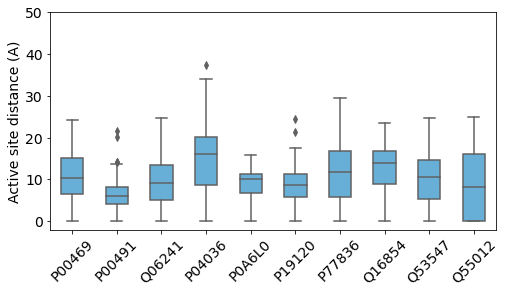

In [921]:
dy=P00469_blue_pred_distribution +P00491_blue_pred_distribution+Q06241_blue_pred_distribution+P04036_blue_pred_distribution+\
P0A6L0_blue_pred_distribution +P19120_blue_pred_distribution+P77836_blue_pred_distribution+Q16854_blue_pred_distribution+Q53547_blue_pred_distribution+\
Q55012_blue_pred_distribution
dx=['P00469' for i in range(len(P00469_blue_pred_distribution))]+['P00491' for i in range(len(P00491_blue_pred_distribution))]+['Q06241' for i in range(len(Q06241_blue_pred_distribution))]+\
['P04036' for i in range(len(P04036_blue_pred_distribution))]+['P0A6L0' for i in range(len(P0A6L0_blue_pred_distribution))]+['P19120' for i in range(len(P19120_blue_pred_distribution))]+\
['P77836' for i in range(len(P77836_blue_pred_distribution))]+['Q16854' for i in range(len(Q16854_blue_pred_distribution))]+['Q53547' for i in range(len(Q53547_blue_pred_distribution))]+\
['Q55012' for i in range(len(Q55012_blue_pred_distribution))]

f, ax = plt.subplots(figsize=(8, 4))



ort = "h"; color = "green"; sigma = .2
sns.boxplot(y = dy,
             x = dx,
             width = .5, ax = ax,color="#56B4E9")

ax.set_ylabel('Active site distance (A)',fontsize=14)

ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(-2,50)

dx_labels=['P00469','P00491','Q06241','P04036','P0A6L0','P19120','P77836','Q16854','Q53547','Q55012']
ax.set_xticklabels(dx_labels,rotation=45,fontsize=14)

plt.savefig('./Figures/SBIR_bar_distance_from_active_site_MCSA_2.pdf')

In [922]:
total_dist=0
count_close=0
for i in dy:
    total_dist+=1
    if i <10:
        count_close+=1
        
print(count_close,total_dist)

144 295


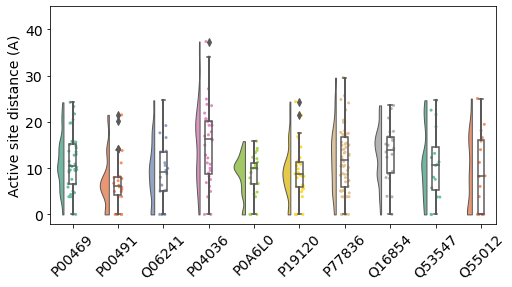

In [923]:
dy=P00469_blue_pred_distribution +P00491_blue_pred_distribution+Q06241_blue_pred_distribution+P04036_blue_pred_distribution+\
P0A6L0_blue_pred_distribution +P19120_blue_pred_distribution+P77836_blue_pred_distribution+Q16854_blue_pred_distribution+Q53547_blue_pred_distribution+\
Q55012_blue_pred_distribution
dx=['P00469' for i in range(len(P00469_blue_pred_distribution))]+['P00491' for i in range(len(P00491_blue_pred_distribution))]+['Q06241' for i in range(len(Q06241_blue_pred_distribution))]+\
['P04036' for i in range(len(P04036_blue_pred_distribution))]+['P0A6L0' for i in range(len(P0A6L0_blue_pred_distribution))]+['P19120' for i in range(len(P19120_blue_pred_distribution))]+\
['P77836' for i in range(len(P77836_blue_pred_distribution))]+['Q16854' for i in range(len(Q16854_blue_pred_distribution))]+['Q53547' for i in range(len(Q53547_blue_pred_distribution))]+\
['Q55012' for i in range(len(Q55012_blue_pred_distribution))]
f, ax = plt.subplots(figsize=(8, 4))




ort = "h"; pal = "Set2"; sigma = .2
pt.RainCloud(y = dy,
             x = dx,
             bw = .3, width_viol = .5, ax = ax,palette=pal)

ax.set_ylabel('Active site distance (A)',fontsize=14)

ax.tick_params(axis="y", labelsize=14)
ax.set_ylim(-2,45)

dx_labels=['P00469','P00491','Q06241','P04036','P0A6L0','P19120','P77836','Q16854','Q53547','Q55012']
ax.set_xticklabels(dx_labels,rotation=45,fontsize=14)

ax.set_ylim(-2,45)
plt.savefig('./Figures/SBIR_distance_from_active_site_MCSA_2.pdf')

In [924]:
for i in act_site_distance_total:
    print(i)

['P00469', 28.316444285962177, 13.669476187831691]
['P00491', 27.69836661249179, 14.063708361115568]
['Q06241', 24.657742861016292, 11.763781816668704]
['P00469', 39.8972497423068, 25.411435485061943]
['P0A6L0', 26.164396075583323, 13.431083793172064]
['P19120', 39.77136903602892, 14.487919405700042]
['P77836', 39.616878637772565, 17.15465796802722]
['Q16854', 25.81617589806826, 16.71832458711099]
['Q53547', 30.27855387894211, 14.487761740895888]
['Q55012', 35.97835346427071, 13.292885234726999]
['Q8VQN0', 21.14368681190676, 10.935640539081376]


### Statistics
to data imported in other notebook (1/2)

In [929]:
print(count_MCSA_matched_over_threshold)

37


In [930]:
print(count_total_SBI_predicted)

[8553, 311]


In [931]:
statistic_threshold_SBI_MCSA=[[0.9,7,50],[0.8,15,88],[0.7,23,120],[0.5,35,184],[0.4,35,234],[0.3,36,277],[0.2,38,355],[0.01,44,711]]

In [932]:
count_catalytic_residues=np.array(count_catalytic_residues)
print(count_catalytic_residues)
np.save('./outputs/count_catalytic_residues_array_2.npy', count_catalytic_residues)

[10 37 11  0  1]


In [933]:
print(count_total_variant)
count_total_variant=np.array(count_total_variant)
np.save('./outputs/count_total_variant_array_2.npy', count_total_variant)

[33722  8553 15133     0]


In [934]:
print(count_total_residues)
count_total_residues=np.array(count_total_residues)
np.save('./outputs/count_total_residues_array_2.npy', count_total_residues)

[1691  311  876    0  149]


calculator statistic

total funct residues

In [936]:
560/(2704+560+1331+227)

0.11613438407299875

total loss catalytic

17 out of 24